In [1]:
# -*- coding: utf-8 -*-
import os
from pathlib import Path
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import GroupKFold, GroupShuffleSplit
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import csv

In [2]:
# ===== Configuración general =====
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Ventana fija por hora (48h)
WINDOW_HOURS = 48
L_MAX = WINDOW_HOURS  # pasos temporales
TS_CHANNELS = 2       # HR + RR/MAP (o HR + Lactato)
D_MODEL = 128
N_HEADS = 4
N_LAYERS = 2
DROPOUT = 0.2
LR = 2e-3
WEIGHT_DECAY = 1e-4
EPOCHS = 20
GRAD_CLIP = 1.0
BATCH_TRAIN = 64
BATCH_VAL = 128
BATCH_TEST = 128

# Diseño de pipeline

In [3]:
import os
import pandas as pd
import numpy as np

DATA_DIR = "/home/gmartinez/Tesis/Datasets/MIMIC-III"

admissions = pd.read_csv(os.path.join(DATA_DIR, "ADMISSIONS.csv"))
patients   = pd.read_csv(os.path.join(DATA_DIR, "PATIENTS.csv"))
labevents  = pd.read_csv(os.path.join(DATA_DIR, "LABEVENTS.csv"))
chartevents = pd.read_csv(os.path.join(DATA_DIR, "CHARTEVENTS.csv"))


In [4]:
for df, cols in [
    (admissions, ["ADMITTIME", "DISCHTIME", "DEATHTIME"]),
    (patients, ["DOB", "DOD"])
]:
    for c in cols:
        if c in df.columns:
            df[c] = pd.to_datetime(df[c])

# Mortalidad hospitalaria
admissions["MORTALITY"] = admissions["DEATHTIME"].notna().astype(int)

In [5]:
# Merge paciente-admisión
adm_pat = admissions.merge(patients, on="SUBJECT_ID", how="left")

In [6]:
print(adm_pat["DOB"].dt.year.value_counts().sort_index().head())
# Verás años como 1600-1700 para pacientes >89

DOB
1800    16
1801    36
1802    38
1803    26
1804    36
Name: count, dtype: int64


In [7]:
adm_pat["ADMITTIME"] = pd.to_datetime(adm_pat["ADMITTIME"], errors="coerce")
adm_pat["DOB"] = pd.to_datetime(adm_pat["DOB"], errors="coerce")

# Extraer años de forma segura
admit_year = adm_pat["ADMITTIME"].dt.year
dob_year = adm_pat["DOB"].dt.year

# Inicializar con 91.4 (asumir >89 por defecto)
adm_pat["AGE"] = 91.4

# Máscara para fechas válidas (DOB > 1900)
valid_mask = (
    adm_pat["ADMITTIME"].notna() & 
    adm_pat["DOB"].notna() & 
    (dob_year > 1900)
)

# Calcular edad aproximada con años (evita timedelta)
adm_pat.loc[valid_mask, "AGE"] = (
    admit_year[valid_mask] - dob_year[valid_mask]
)

# Refinamiento opcional con meses/días (solo si no da overflow)
try:
    delta_days = (
        adm_pat.loc[valid_mask, "ADMITTIME"] - 
        adm_pat.loc[valid_mask, "DOB"]
    ).dt.days
    adm_pat.loc[valid_mask, "AGE"] = delta_days / 365.25
except (OverflowError, AttributeError):
    pass  # Mantener la edad aproximada por años

# Cap a 89
adm_pat.loc[adm_pat["AGE"] > 89, "AGE"] = 89

In [8]:
# Número de ingresos previos del mismo paciente
adm_pat = adm_pat.sort_values(["SUBJECT_ID", "ADMITTIME"])
adm_pat["NUM_PREV_ADM"] = (
    adm_pat.groupby("SUBJECT_ID").cumcount()
)  # 0 = primer ingreso

context_cols = [
    "HADM_ID",
    "SUBJECT_ID",
    "MORTALITY",
    "AGE",
    "GENDER",
    "INSURANCE",
    "ADMISSION_TYPE",
    "ADMISSION_LOCATION",
    "ETHNICITY",
    "NUM_PREV_ADM",
    "ADMITTIME",
    "DISCHTIME",
]

cohort = adm_pat[context_cols].copy()

In [9]:
# Especificar ventana de tiempo
from datetime import timedelta

WINDOW_DAYS = 7
WINDOW_HOURS = WINDOW_DAYS * 24


In [10]:
hadm_to_admit = cohort.set_index("HADM_ID")["ADMITTIME"].to_dict()

In [11]:
# Columnas mínimas necesarias
lab_cols = ["HADM_ID", "ITEMID", "CHARTTIME", "VALUENUM"]
labevents = labevents[lab_cols].copy()
labevents["CHARTTIME"] = pd.to_datetime(labevents["CHARTTIME"])

# Filtrar a admisiones de la cohorte
hadm_ids = set(cohort["HADM_ID"])
labevents = labevents[labevents["HADM_ID"].isin(hadm_ids)]

# Tiempo relativo
def compute_rel_hours(row):
    admit = hadm_to_admit.get(row["HADM_ID"], None)
    if admit is None:
        return np.nan
    return (row["CHARTTIME"] - admit).total_seconds() / 3600.0

labevents["REL_HOURS"] = labevents.apply(compute_rel_hours, axis=1)
labevents = labevents[
    (labevents["REL_HOURS"] >= 0) &
    (labevents["REL_HOURS"] <= WINDOW_HOURS)
]

# Conteo de admisiones por ITEMID
lab_item_coverage = (
    labevents.dropna(subset=["VALUENUM"])
             .groupby("ITEMID")["HADM_ID"]
             .nunique()
             .sort_values(ascending=False)
)

In [12]:
d_labitems = pd.read_csv(os.path.join(DATA_DIR, "D_LABITEMS.csv"))
lab_stats = (
    lab_item_coverage
    .reset_index()
    .merge(d_labitems[["ITEMID", "LABEL"]], on="ITEMID", how="left")
    .sort_values("HADM_ID", ascending=False)
)

print(lab_stats.head(20))

    ITEMID  HADM_ID              LABEL
0    51221    55465         Hematocrit
1    51265    55248     Platelet Count
2    51301    55239  White Blood Cells
3    51222    55191         Hemoglobin
4    51249    55183               MCHC
6    51250    55176                MCV
5    51248    55176                MCH
7    51279    55176    Red Blood Cells
8    51277    55165                RDW
9    50971    52323          Potassium
10   50983    52299             Sodium
11   50902    52285           Chloride
12   50882    52255        Bicarbonate
13   50868    52236          Anion Gap
14   50912    50152         Creatinine
15   51006    50148      Urea Nitrogen
16   50931    49790            Glucose
17   50960    49323          Magnesium
18   50893    47760     Calcium, Total
19   50970    47696          Phosphate


In [13]:
# Intentar priorizar glucosa
glucose_candidate = lab_stats[lab_stats["LABEL"].str.contains("GLUCOSE", case=False, na=False)]
if len(glucose_candidate) > 0:
    LAB_ITEMID = int(glucose_candidate.iloc[0]["ITEMID"])
else:
    LAB_ITEMID = int(lab_stats.iloc[0]["ITEMID"])

print("Selected LAB ITEMID:", LAB_ITEMID)

Selected LAB ITEMID: 50931


In [14]:
chart_cols = ["HADM_ID", "ITEMID", "CHARTTIME", "VALUENUM"]
chartevents = chartevents[chart_cols].copy()
chartevents["CHARTTIME"] = pd.to_datetime(chartevents["CHARTTIME"])

chartevents = chartevents[chartevents["HADM_ID"].isin(hadm_ids)]

def compute_rel_hours_chart(row):
    admit = hadm_to_admit.get(row["HADM_ID"], None)
    if admit is None:
        return np.nan
    return (row["CHARTTIME"] - admit).total_seconds() / 3600.0

chartevents["REL_HOURS"] = chartevents.apply(compute_rel_hours_chart, axis=1)
chartevents = chartevents[
    (chartevents["REL_HOURS"] >= 0) &
    (chartevents["REL_HOURS"] <= WINDOW_HOURS)
]

chart_item_coverage = (
    chartevents.dropna(subset=["VALUENUM"])
               .groupby("ITEMID")["HADM_ID"]
               .nunique()
               .sort_values(ascending=False)
)

d_items = pd.read_csv(os.path.join(DATA_DIR, "D_LABITEMS.csv"))
chart_stats = (
    chart_item_coverage
    .reset_index()
    .merge(d_items[["ITEMID", "LABEL"]], on="ITEMID", how="left")
    .sort_values("HADM_ID", ascending=False)
)

print(chart_stats.head(30))

      ITEMID  HADM_ID LABEL
0   220602.0    15256   NaN
1   220615.0    15254   NaN
2   225624.0    15253   NaN
3   227443.0    15252   NaN
4   220545.0    15232   NaN
5   220645.0    15229   NaN
6   227442.0    15224   NaN
7   227457.0    15195   NaN
8   227073.0    15194   NaN
9   220546.0    15193   NaN
10  220228.0    15191   NaN
11  220621.0    15169   NaN
12  220635.0    14814   NaN
13  225677.0    14289   NaN
14  225625.0    14285   NaN
15  220045.0    13104   NaN
16  220210.0    13100   NaN
17  220277.0    13094   NaN
18  220047.0    13058   NaN
20  220046.0    13055   NaN
19  223770.0    13055   NaN
21  223769.0    13053   NaN
22  224161.0    13048   NaN
23  224162.0    13048   NaN
24  227467.0    13039   NaN
25  227465.0    13038   NaN
26  227466.0    12951   NaN
27  226253.0    12946   NaN
28  223761.0    12896   NaN
29  220179.0    12866   NaN


In [15]:
hr_candidate = chart_stats[chart_stats["LABEL"].str.contains("Heart Rate", case=False, na=False)]
spo2_candidate = chart_stats[chart_stats["LABEL"].str.contains("O2 Saturation", case=False, na=False)]

if len(hr_candidate) > 0:
    VITAL_ITEMID = int(hr_candidate.iloc[0]["ITEMID"])
elif len(spo2_candidate) > 0:
    VITAL_ITEMID = int(spo2_candidate.iloc[0]["ITEMID"])
else:
    VITAL_ITEMID = int(chart_stats.iloc[0]["ITEMID"])

print("Selected VITAL ITEMID:", VITAL_ITEMID)

Selected VITAL ITEMID: 220602


In [16]:
lab_ts = labevents[labevents["ITEMID"] == LAB_ITEMID].copy()
vital_ts = chartevents[chartevents["ITEMID"] == VITAL_ITEMID].copy()

# Asegurar orden por tiempo
lab_ts = lab_ts.sort_values(["HADM_ID", "REL_HOURS"])
vital_ts = vital_ts.sort_values(["HADM_ID", "REL_HOURS"])

In [17]:
from collections import defaultdict

def build_series_per_hadm(df, value_col="VALUENUM"):
    """
    df debe tener columnas: HADM_ID, REL_HOURS, VALUENUM
    Devuelve dict: hadm_id -> (t, x, m)
    """
    series = {}
    for hadm_id, grp in df.groupby("HADM_ID"):
        grp = grp.dropna(subset=[value_col, "REL_HOURS"])
        if grp.empty:
            continue
        t = grp["REL_HOURS"].values.astype(float)
        x = grp[value_col].values.astype(float)
        m = np.ones_like(x, dtype=int)
        series[hadm_id] = (t, x, m)
    return series

lab_series = build_series_per_hadm(lab_ts)
vital_series = build_series_per_hadm(vital_ts)

In [18]:
MAX_SAMPLES = 20000  # parámetro que puedes bajar

# Quedarnos solo con HADM_ID que tienen al menos alguna serie
valid_hadm_ids = set(lab_series.keys()) & set(vital_series.keys())
cohort_sub = cohort[cohort["HADM_ID"].isin(valid_hadm_ids)].copy()

# Barajar y cortar
cohort_sub = cohort_sub.sample(frac=1, random_state=42).head(MAX_SAMPLES)

In [19]:
context_cat_cols = ["GENDER", "INSURANCE", "ADMISSION_TYPE",
                    "ADMISSION_LOCATION", "ETHNICITY"]
context_num_cols = ["AGE", "NUM_PREV_ADM"]

# One-hot para categóricas
context_cat_dummies = pd.get_dummies(
    cohort_sub[context_cat_cols],
    dummy_na=True,
    prefix=context_cat_cols
)

context_num = cohort_sub[context_num_cols].fillna(cohort_sub[context_num_cols].mean())

context_matrix = np.hstack([context_num.values, context_cat_dummies.values])
context_feature_names = (
    context_num_cols + list(context_cat_dummies.columns)
)

In [20]:
examples = []

for idx, row in cohort_sub.iterrows():
    hadm_id = row["HADM_ID"]
    if (hadm_id not in lab_series) or (hadm_id not in vital_series):
        continue

    t_lab, x_lab, m_lab = lab_series[hadm_id]
    t_vital, x_vital, m_vital = vital_series[hadm_id]

    # Requerir mínimo de puntos en cada serie
    if len(t_lab) < 3 or len(t_vital) < 3:
        continue

    y = int(row["MORTALITY"])

    context_vec = np.hstack([
        context_num.loc[idx].values,
        context_cat_dummies.loc[idx].values
    ])

    examples.append({
        "hadm_id": hadm_id,
        "subject_id": row["SUBJECT_ID"],
        "label": y,
        "context": context_vec.astype(float),
        "t_lab": t_lab,
        "x_lab": x_lab,
        "m_lab": m_lab,
        "t_vital": t_vital,
        "x_vital": x_vital,
        "m_vital": m_vital,
    })

len(examples)

9240

In [21]:
import pickle

OUTPUT_PATH = "/home/gmartinez/Tesis/Datasets/MIMIC-III/mimic_mtan_glucose_hr_7d.pkl"

with open(OUTPUT_PATH, "wb") as f:
    pickle.dump({
        "examples": examples,
        "context_feature_names": context_feature_names,
        "lab_itemid": LAB_ITEMID,
        "vital_itemid": VITAL_ITEMID,
        "window_hours": WINDOW_HOURS,
    }, f)

In [22]:
import torch
from torch.utils.data import Dataset

class MTANMimicDataset(Dataset):
    def __init__(self, examples):
        self.examples = examples

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        ex = self.examples[idx]

        return {
            "label": torch.tensor(ex["label"], dtype=torch.float32),
            "context": torch.tensor(ex["context"], dtype=torch.float32),

            "t_lab": torch.tensor(ex["t_lab"], dtype=torch.float32),
            "x_lab": torch.tensor(ex["x_lab"], dtype=torch.float32),
            "m_lab": torch.tensor(ex["m_lab"], dtype=torch.float32),

            "t_vital": torch.tensor(ex["t_vital"], dtype=torch.float32),
            "x_vital": torch.tensor(ex["x_vital"], dtype=torch.float32),
            "m_vital": torch.tensor(ex["m_vital"], dtype=torch.float32),
        }

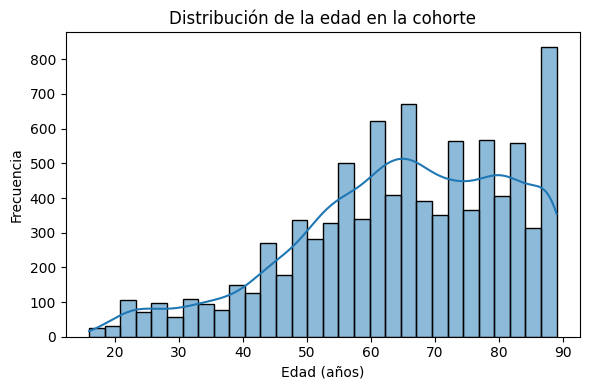

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

ages = [ex["context"][0] for ex in examples]  # suponiendo AGE es la primera

plt.figure(figsize=(6,4))
sns.histplot(ages, kde=True, bins=30)
plt.title("Distribución de la edad en la cohorte")
plt.xlabel("Edad (años)")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()

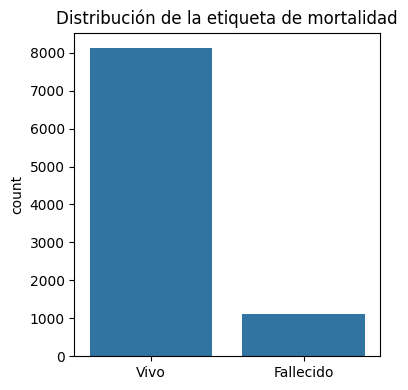

Tasa de mortalidad en la muestra: 0.12164502164502164


In [24]:
labels = np.array([ex["label"] for ex in examples])

plt.figure(figsize=(4,4))
sns.countplot(x=labels)
plt.xticks([0,1], ["Vivo", "Fallecido"])
plt.title("Distribución de la etiqueta de mortalidad")
plt.tight_layout()
plt.show()

mortality_rate = labels.mean()
print("Tasa de mortalidad en la muestra:", mortality_rate)

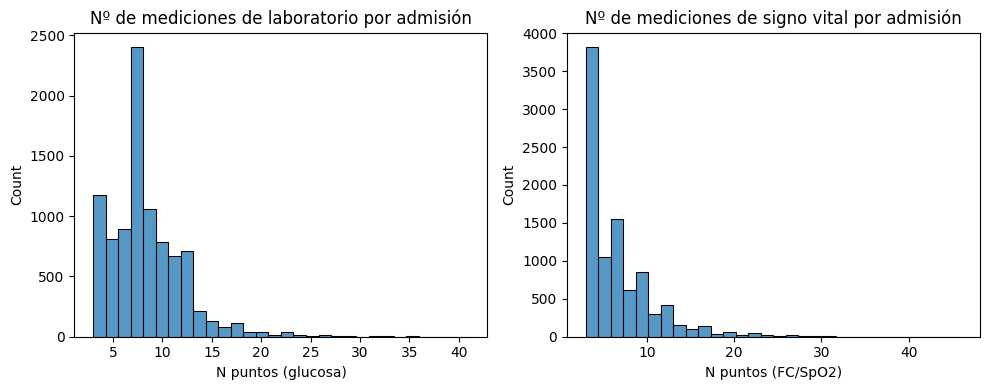

In [25]:
n_lab_points = np.array([len(ex["t_lab"]) for ex in examples])
n_vital_points = np.array([len(ex["t_vital"]) for ex in examples])

fig, axs = plt.subplots(1, 2, figsize=(10,4))
sns.histplot(n_lab_points, bins=30, ax=axs[0])
axs[0].set_title("Nº de mediciones de laboratorio por admisión")
axs[0].set_xlabel("N puntos (glucosa)")
sns.histplot(n_vital_points, bins=30, ax=axs[1])
axs[1].set_title("Nº de mediciones de signo vital por admisión")
axs[1].set_xlabel("N puntos (FC/SpO2)")
plt.tight_layout()
plt.show()

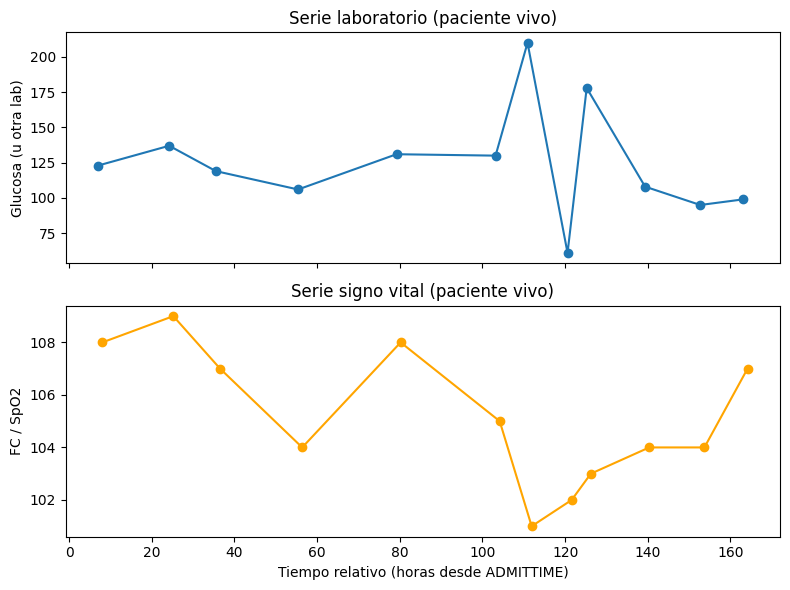

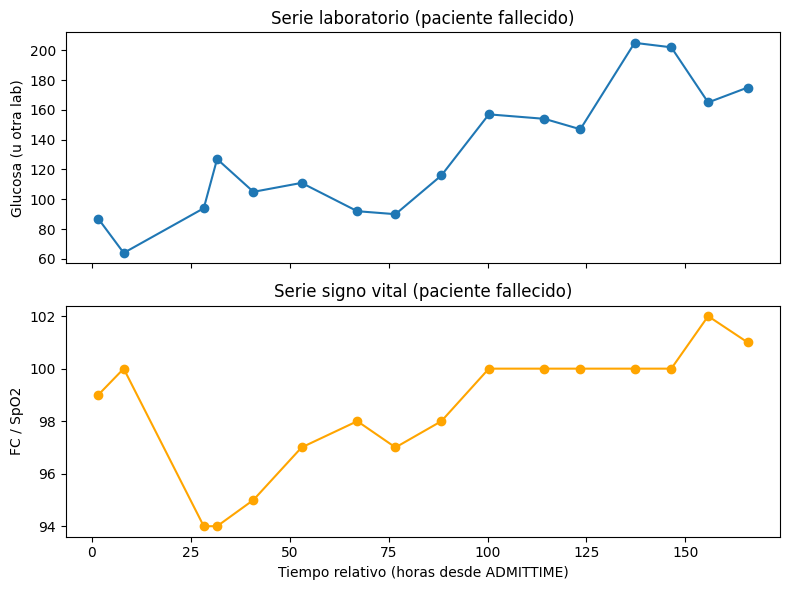

In [26]:
def plot_example(ex, title_suffix=""):
    fig, axs = plt.subplots(2, 1, figsize=(8,6), sharex=True)

    axs[0].plot(ex["t_lab"], ex["x_lab"], "o-")
    axs[0].set_ylabel("Glucosa (u otra lab)")
    axs[0].set_title(f"Serie laboratorio {title_suffix}")

    axs[1].plot(ex["t_vital"], ex["x_vital"], "o-", color="orange")
    axs[1].set_ylabel("FC / SpO2")
    axs[1].set_xlabel("Tiempo relativo (horas desde ADMITTIME)")
    axs[1].set_title(f"Serie signo vital {title_suffix}")

    plt.tight_layout()
    plt.show()

# Ejemplo: uno vivo y uno fallecido
alive_idx = next(i for i,e in enumerate(examples) if e["label"] == 0)
dead_idx  = next(i for i,e in enumerate(examples) if e["label"] == 1)

plot_example(examples[alive_idx], title_suffix="(paciente vivo)")
plot_example(examples[dead_idx], title_suffix="(paciente fallecido)")

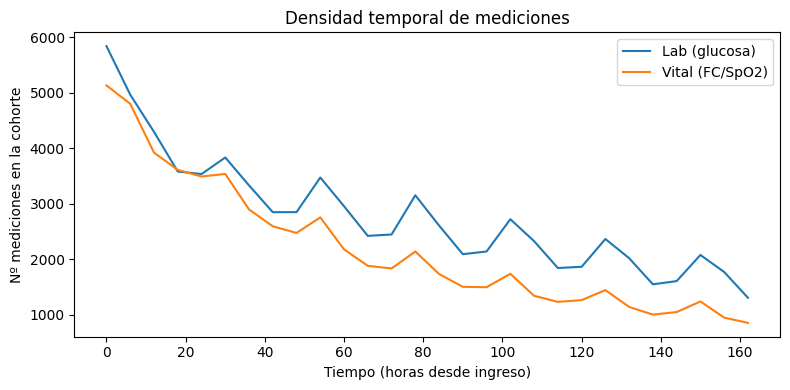

In [27]:
# Binning de tiempos (por ejemplo, en bloques de 6 horas)
bin_width = 6
max_time = WINDOW_HOURS
bins = np.arange(0, max_time + bin_width, bin_width)

lab_hist = np.zeros(len(bins)-1)
vital_hist = np.zeros(len(bins)-1)

for ex in examples:
    lab_hist += np.histogram(ex["t_lab"], bins=bins)[0]
    vital_hist += np.histogram(ex["t_vital"], bins=bins)[0]

plt.figure(figsize=(8,4))
plt.plot(bins[:-1], lab_hist, label="Lab (glucosa)")
plt.plot(bins[:-1], vital_hist, label="Vital (FC/SpO2)")
plt.xlabel("Tiempo (horas desde ingreso)")
plt.ylabel("Nº mediciones en la cohorte")
plt.title("Densidad temporal de mediciones")
plt.legend()
plt.tight_layout()
plt.show()

In [28]:
import pickle
from pathlib import Path

DATA_PKL = Path("/home/gmartinez/Tesis/Datasets/MIMIC-III/mimic_mtan_glucose_hr_7d.pkl")

with open(DATA_PKL, "rb") as f:
    data = pickle.load(f)

print(type(data))
if isinstance(data, dict):
    print("Claves del dict:\n", list(data.keys()))
else:
    # por si guardaste una tupla/lista en lugar de dict
    print("Objeto no es dict, es:", type(data))
    try:
        print("Longitud:", len(data))
    except TypeError:
        pass

<class 'dict'>
Claves del dict:
 ['examples', 'context_feature_names', 'lab_itemid', 'vital_itemid', 'window_hours']


In [29]:
import pickle
from pathlib import Path

DATA_PKL = Path("/home/gmartinez/Tesis/Datasets/MIMIC-III/mimic_mtan_glucose_hr_7d.pkl")

with open(DATA_PKL, "rb") as f:
    data_raw = pickle.load(f)

print(type(data_raw))
print("Claves top-level:", list(data_raw.keys()))

examples = data_raw["examples"]
print("Nº de ejemplos:", len(examples))
print("Tipo de un ejemplo:", type(examples[0]))

# Mirar claves de un solo ejemplo
print("Claves del primer ejemplo:", examples[0].keys())
for k,v in examples[0].items():
    if isinstance(v, (list, tuple)):
        print(f"  {k}: tipo={type(v)}, len={len(v)}")
    else:
        print(f"  {k}: tipo={type(v)}, shape={getattr(v, 'shape', 'N/A')}, valor_muestra={str(v)[:60]}")

<class 'dict'>
Claves top-level: ['examples', 'context_feature_names', 'lab_itemid', 'vital_itemid', 'window_hours']
Nº de ejemplos: 9240
Tipo de un ejemplo: <class 'dict'>
Claves del primer ejemplo: dict_keys(['hadm_id', 'subject_id', 'label', 'context', 't_lab', 'x_lab', 'm_lab', 't_vital', 'x_vital', 'm_vital'])
  hadm_id: tipo=<class 'int'>, shape=N/A, valor_muestra=153621
  subject_id: tipo=<class 'int'>, shape=N/A, valor_muestra=17539
  label: tipo=<class 'int'>, shape=N/A, valor_muestra=0
  context: tipo=<class 'numpy.ndarray'>, shape=(65,), valor_muestra=[43.  3.  0.  1.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.
  t_lab: tipo=<class 'numpy.ndarray'>, shape=(12,), valor_muestra=[  7.03333333  24.2         35.51666667  55.38333333  79.2
 
  x_lab: tipo=<class 'numpy.ndarray'>, shape=(12,), valor_muestra=[123. 137. 119. 106. 131. 130. 210.  61. 178. 108.  95.  99.
  m_lab: tipo=<class 'numpy.ndarray'>, shape=(12,), valor_muestra=[1 1 1 1 1 1 1 1 1 1 1 1]
  t_vital: tipo=<class '

In [30]:
import pickle
import numpy as np
from pathlib import Path

def load_mimic_glucose_hr(pkl_path: Path):
    """
    Carga mimic_mtan_glucose_hr_7d.pkl y fusiona las series de lab y vital
    en un único eje temporal por episodio (unión de t_lab y t_vital).

    Para cada episodio i:
      - T_i = sorted(unique(t_lab_i ∪ t_vital_i))
      - X_i[t_idx, 0] = valor de lab en ese tiempo si existe, si no 0
      - X_i[t_idx, 1] = valor de vital en ese tiempo si existe, si no 0
      - M_i[t_idx, 0/1] = 1 si hay medida para ese canal en ese tiempo, si no 0

    Luego se hace padding a L_max = max_i |T_i|.

    Devuelve:
      X_all: (N, L_max, 2)
      T_all: (N, L_max)
      M_all: (N, L_max, 2)
      y_all: (N,)
      user_ids_all: (N,)
      P_all: (N, P_dim)
      meta_info: dict
    """
    print(f"[load_mimic_glucose_hr] Cargando desde: {pkl_path}")

    with open(pkl_path, "rb") as f:
        data = pickle.load(f)

    assert isinstance(data, dict)
    examples = data["examples"]
    ctx_names = data.get("context_feature_names", None)

    lab_itemid = data.get("lab_itemid", None)
    vital_itemid = data.get("vital_itemid", None)
    window_hours = data.get("window_hours", None)

    N = len(examples)
    print("[load_mimic_glucose_hr] Nº de ejemplos:", N)

    # --- Paso 1: construir grids por episodio y medir L_max ---
    per_episode_T = []    # listas de np.array tiempos fusionados
    per_episode_L = []    # longitudes fusionadas

    for i, ex in enumerate(examples):
        t_lab = np.asarray(ex["t_lab"], dtype=np.float32)
        t_vital = np.asarray(ex["t_vital"], dtype=np.float32)

        # unión de tiempos (manteniendo orden)
        T_i = np.unique(np.concatenate([t_lab, t_vital]))
        per_episode_T.append(T_i)
        per_episode_L.append(len(T_i))

    L_max = int(max(per_episode_L))
    print("[load_mimic_glucose_hr] Longitudes fusionadas únicas:", sorted(set(per_episode_L)))
    print("[load_mimic_glucose_hr] Longitud máxima L_max:", L_max)

    # --- Paso 2: dim de contexto ---
    ex0 = examples[0]
    context0 = np.asarray(ex0["context"], dtype=np.float32)
    if context0.ndim != 1:
        raise ValueError(f"context del ejemplo 0 no es vector 1D, shape={context0.shape}")
    P_dim = context0.shape[0]

    C = 2  # canales: lab, vital

    # --- Paso 3: inicializar tensores con padding ---
    X_all = np.zeros((N, L_max, C), dtype=np.float32)
    T_all = np.zeros((N, L_max), dtype=np.float32)
    M_all = np.zeros((N, L_max, C), dtype=np.float32)
    y_all = np.zeros((N,), dtype=np.float32)
    user_ids_all = np.empty((N,), dtype=object)
    P_all = np.zeros((N, P_dim), dtype=np.float32)

    # --- Paso 4: rellenar episodio a episodio ---
    for i, ex in enumerate(examples):
        T_i = per_episode_T[i]
        L_i = len(T_i)

        t_lab   = np.asarray(ex["t_lab"], dtype=np.float32)
        x_lab   = np.asarray(ex["x_lab"], dtype=np.float32)
        m_lab   = np.asarray(ex["m_lab"], dtype=np.float32)

        t_vital = np.asarray(ex["t_vital"], dtype=np.float32)
        x_vital = np.asarray(ex["x_vital"], dtype=np.float32)
        m_vital = np.asarray(ex["m_vital"], dtype=np.float32)

        # comprobamos coherencia mínima
        if not (len(t_lab) == len(x_lab) == len(m_lab)):
            raise ValueError(f"[ejemplo {i}] lab con longitudes inconsistentes: "
                             f"t_lab={len(t_lab)}, x_lab={len(x_lab)}, m_lab={len(m_lab)}")
        if not (len(t_vital) == len(x_vital) == len(m_vital)):
            raise ValueError(f"[ejemplo {i}] vital con longitudes inconsistentes: "
                             f"t_vital={len(t_vital)}, x_vital={len(x_vital)}, m_vital={len(m_vital)}")

        # mapeo: tiempo -> valor para cada canal
        # Canal 0: lab
        lab_dict_x = {float(t): float(v) for t, v in zip(t_lab, x_lab)}
        lab_dict_m = {float(t): float(m) for t, m in zip(t_lab, m_lab)}

        # Canal 1: vital
        vital_dict_x = {float(t): float(v) for t, v in zip(t_vital, x_vital)}
        vital_dict_m = {float(t): float(m) for t, m in zip(t_vital, m_vital)}

        # rellenar primeros L_i pasos
        T_all[i, :L_i] = T_i

        # para cada tiempo en el grid fusionado, rellenar valores y máscaras
        for j, t in enumerate(T_i):
            t_key = float(t)

            # lab
            if t_key in lab_dict_x:
                X_all[i, j, 0] = lab_dict_x[t_key]
                M_all[i, j, 0] = lab_dict_m[t_key]
            # vital
            if t_key in vital_dict_x:
                X_all[i, j, 1] = vital_dict_x[t_key]
                M_all[i, j, 1] = vital_dict_m[t_key]

        # resto de L_max ya queda en 0 (padding)
        y_all[i] = float(ex["label"])
        user_ids_all[i] = str(ex["hadm_id"])
        P_all[i, :] = np.asarray(ex["context"], dtype=np.float32)

    print("[load_mimic_glucose_hr] Shapes finales:")
    print("  X_all:", X_all.shape, X_all.dtype)
    print("  T_all:", T_all.shape, T_all.dtype)
    print("  M_all:", M_all.shape, M_all.dtype)
    print("  y_all:", y_all.shape, y_all.dtype)
    print("  P_all:", P_all.shape, P_all.dtype)
    print("  user_ids_all:", user_ids_all.shape, type(user_ids_all[0]))
    if ctx_names is not None:
        print("  Nº context_feature_names:", len(ctx_names))

    meta_info = {
        "context_feature_names": ctx_names,
        "lab_itemid": lab_itemid,
        "vital_itemid": vital_itemid,
        "window_hours": window_hours,
        "L_max": L_max,
    }
    return X_all, T_all, M_all, y_all, user_ids_all, P_all, meta_info

In [31]:
from pathlib import Path

DATA_PKL = Path("/home/gmartinez/Tesis/Datasets/MIMIC-III/mimic_mtan_glucose_hr_7d.pkl")

print(">>> Llamando a load_mimic_glucose_hr...")
X_all, T_all, M_all, y_all, user_ids_all, P_all, meta_info = load_mimic_glucose_hr(DATA_PKL)

print("\n>>> Tipos devueltos:")
print("type(X_all):", type(X_all))
print("type(T_all):", type(T_all))
print("type(M_all):", type(M_all))
print("type(y_all):", type(y_all))
print("type(user_ids_all):", type(user_ids_all))
print("type(P_all):", type(P_all))

print("\n>>> Shapes:")
print("X_all.shape:", X_all.shape)
print("T_all.shape:", T_all.shape)
print("M_all.shape:", M_all.shape)
print("y_all.shape:", y_all.shape)
print("P_all.shape:", P_all.shape)

L_MAX = X_all.shape[1]
in_channels = X_all.shape[2]
p_dim = P_all.shape[1]

print("\nL_MAX:", L_MAX, "in_channels:", in_channels, "p_dim:", p_dim)

>>> Llamando a load_mimic_glucose_hr...
[load_mimic_glucose_hr] Cargando desde: /home/gmartinez/Tesis/Datasets/MIMIC-III/mimic_mtan_glucose_hr_7d.pkl
[load_mimic_glucose_hr] Nº de ejemplos: 9240
[load_mimic_glucose_hr] Longitudes fusionadas únicas: [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 62, 63, 64, 67]
[load_mimic_glucose_hr] Longitud máxima L_max: 67
[load_mimic_glucose_hr] Shapes finales:
  X_all: (9240, 67, 2) float32
  T_all: (9240, 67) float32
  M_all: (9240, 67, 2) float32
  y_all: (9240,) float32
  P_all: (9240, 65) float32
  user_ids_all: (9240,) <class 'str'>
  Nº context_feature_names: 65

>>> Tipos devueltos:
type(X_all): <class 'numpy.ndarray'>
type(T_all): <class 'numpy.ndarray'>
type(M_all): <class 'numpy.ndarray'>
type(y_all): <class 'numpy.ndarray'>
type(user_ids_all): <class 'numpy.ndarray'>
type(

DEVICE: cuda
[MIMIC-III] Train/Val instancias: 7392 | Test instancias: 1848 | Usuarios únicos TV: 7392 | Usuarios únicos Test: 1848
[MIMIC-III] === Fold 1 ===
[MIMIC-III] P1 | Epoch 01 | train_loss=0.3624 val_loss=0.4113 | AUROC train/val=0.528/0.623 | AUPRC train/val=0.130/0.203
[MIMIC-III] P1 | Epoch 02 | train_loss=0.3535 val_loss=0.3825 | AUROC train/val=0.568/0.587 | AUPRC train/val=0.146/0.184
[MIMIC-III] P1 | Epoch 03 | train_loss=0.3532 val_loss=0.3838 | AUROC train/val=0.568/0.586 | AUPRC train/val=0.148/0.180
[MIMIC-III] P1 | Epoch 04 | train_loss=0.3674 val_loss=0.4145 | AUROC train/val=0.468/0.525 | AUPRC train/val=0.105/0.150
[MIMIC-III] P1 | Epoch 05 | train_loss=0.3597 val_loss=0.3891 | AUROC train/val=0.482/0.367 | AUPRC train/val=0.108/0.098
[MIMIC-III] P1 | Epoch 06 | train_loss=0.3575 val_loss=0.3927 | AUROC train/val=0.505/0.373 | AUPRC train/val=0.119/0.100
[MIMIC-III] P1 | Epoch 07 | train_loss=0.3562 val_loss=0.3903 | AUROC train/val=0.496/0.605 | AUPRC train/val

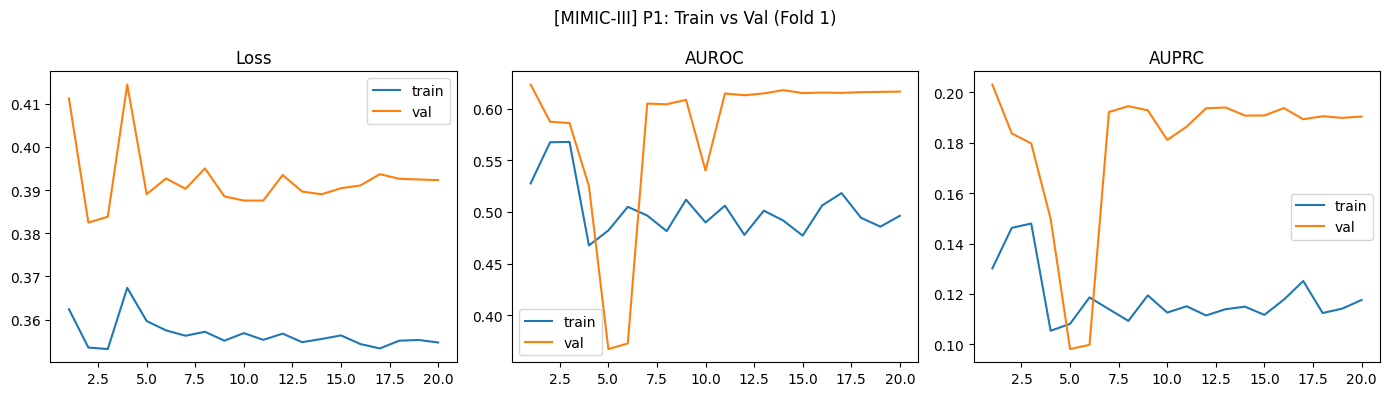

[MIMIC-III] P2 | Epoch 01 | train_loss=0.3688 val_loss=0.3781 | AUROC train/val=0.525/0.655 | AUPRC train/val=0.128/0.239
[MIMIC-III] P2 | Epoch 02 | train_loss=0.3544 val_loss=0.3853 | AUROC train/val=0.585/0.632 | AUPRC train/val=0.157/0.202
[MIMIC-III] P2 | Epoch 03 | train_loss=0.3458 val_loss=0.3920 | AUROC train/val=0.616/0.657 | AUPRC train/val=0.164/0.223
[MIMIC-III] P2 | Epoch 04 | train_loss=0.3376 val_loss=0.3835 | AUROC train/val=0.659/0.666 | AUPRC train/val=0.183/0.227
[MIMIC-III] P2 | Epoch 05 | train_loss=0.3355 val_loss=0.3718 | AUROC train/val=0.668/0.671 | AUPRC train/val=0.189/0.228
[MIMIC-III] P2 | Epoch 06 | train_loss=0.3349 val_loss=0.3739 | AUROC train/val=0.671/0.672 | AUPRC train/val=0.188/0.222
[MIMIC-III] P2 | Epoch 07 | train_loss=0.3370 val_loss=0.3685 | AUROC train/val=0.661/0.665 | AUPRC train/val=0.180/0.221
[MIMIC-III] P2 | Epoch 08 | train_loss=0.3352 val_loss=0.3686 | AUROC train/val=0.668/0.670 | AUPRC train/val=0.173/0.232
[MIMIC-III] P2 | Epoch 0

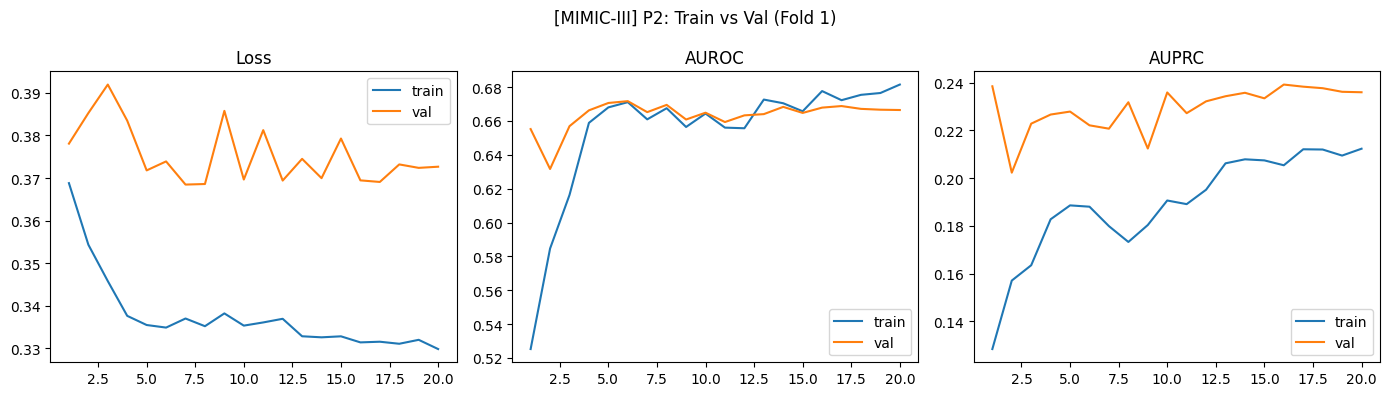

[MIMIC-III] P3 | Epoch 01 | train_loss=0.3800 val_loss=0.3929 | AUROC train/val=0.499/0.622 | AUPRC train/val=0.114/0.197
[MIMIC-III] P3 | Epoch 02 | train_loss=0.3462 val_loss=0.3762 | AUROC train/val=0.616/0.665 | AUPRC train/val=0.165/0.232
[MIMIC-III] P3 | Epoch 03 | train_loss=0.3389 val_loss=0.3702 | AUROC train/val=0.654/0.678 | AUPRC train/val=0.179/0.239
[MIMIC-III] P3 | Epoch 04 | train_loss=0.3388 val_loss=0.3683 | AUROC train/val=0.654/0.692 | AUPRC train/val=0.184/0.250
[MIMIC-III] P3 | Epoch 05 | train_loss=0.3344 val_loss=0.3678 | AUROC train/val=0.680/0.695 | AUPRC train/val=0.212/0.257
[MIMIC-III] P3 | Epoch 06 | train_loss=0.3339 val_loss=0.3673 | AUROC train/val=0.670/0.688 | AUPRC train/val=0.195/0.272
[MIMIC-III] P3 | Epoch 07 | train_loss=0.3296 val_loss=0.3597 | AUROC train/val=0.689/0.691 | AUPRC train/val=0.220/0.267
[MIMIC-III] P3 | Epoch 08 | train_loss=0.3282 val_loss=0.3800 | AUROC train/val=0.694/0.694 | AUPRC train/val=0.225/0.283
[MIMIC-III] P3 | Epoch 0

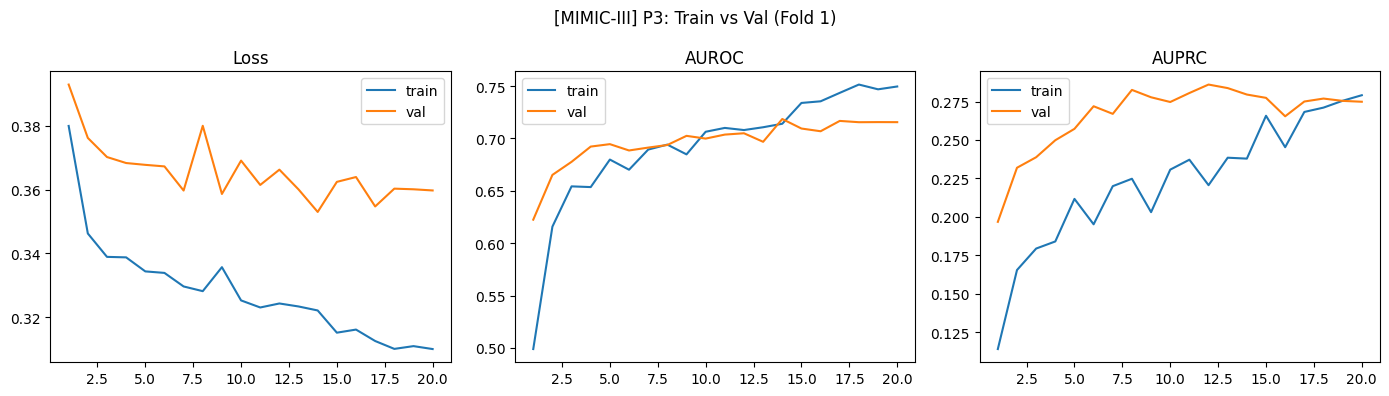

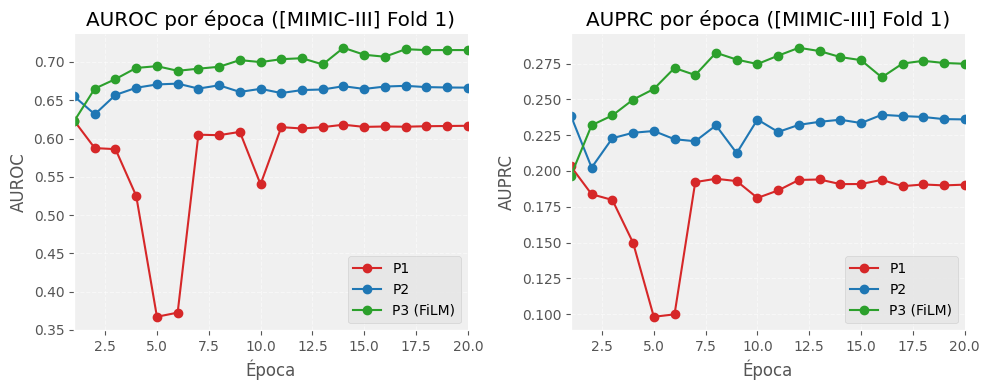

[MIMIC-III] Fold 1 | Test AUROC P1/P2/P3 = 0.578 / 0.615 / 0.697 | AUPRC P1/P2/P3 = 0.157 / 0.186 / 0.258
[MIMIC-III] === Fold 2 ===
[MIMIC-III] P1 | Epoch 01 | train_loss=0.3719 val_loss=0.3632 | AUROC train/val=0.575/0.610 | AUPRC train/val=0.162/0.185
[MIMIC-III] P1 | Epoch 02 | train_loss=0.3516 val_loss=0.3584 | AUROC train/val=0.659/0.623 | AUPRC train/val=0.204/0.191
[MIMIC-III] P1 | Epoch 03 | train_loss=0.3518 val_loss=0.3528 | AUROC train/val=0.657/0.632 | AUPRC train/val=0.222/0.193
[MIMIC-III] P1 | Epoch 04 | train_loss=0.3408 val_loss=0.3442 | AUROC train/val=0.698/0.685 | AUPRC train/val=0.240/0.247
[MIMIC-III] P1 | Epoch 05 | train_loss=0.3366 val_loss=0.3489 | AUROC train/val=0.712/0.679 | AUPRC train/val=0.264/0.230
[MIMIC-III] P1 | Epoch 06 | train_loss=0.3356 val_loss=0.3448 | AUROC train/val=0.719/0.685 | AUPRC train/val=0.250/0.255
[MIMIC-III] P1 | Epoch 07 | train_loss=0.3292 val_loss=0.3439 | AUROC train/val=0.735/0.699 | AUPRC train/val=0.291/0.260
[MIMIC-III] P

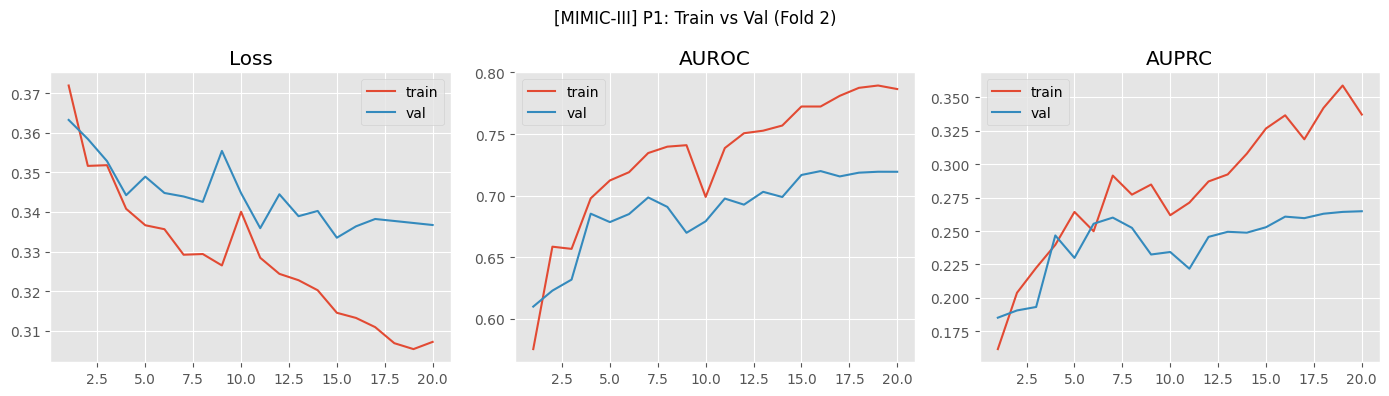

[MIMIC-III] P2 | Epoch 01 | train_loss=0.3629 val_loss=0.3465 | AUROC train/val=0.631/0.673 | AUPRC train/val=0.192/0.220
[MIMIC-III] P2 | Epoch 02 | train_loss=0.3453 val_loss=0.3374 | AUROC train/val=0.688/0.695 | AUPRC train/val=0.228/0.240
[MIMIC-III] P2 | Epoch 03 | train_loss=0.3412 val_loss=0.3782 | AUROC train/val=0.699/0.656 | AUPRC train/val=0.254/0.204
[MIMIC-III] P2 | Epoch 04 | train_loss=0.3456 val_loss=0.3386 | AUROC train/val=0.684/0.690 | AUPRC train/val=0.221/0.251
[MIMIC-III] P2 | Epoch 05 | train_loss=0.3277 val_loss=0.3401 | AUROC train/val=0.743/0.704 | AUPRC train/val=0.280/0.265
[MIMIC-III] P2 | Epoch 06 | train_loss=0.3307 val_loss=0.3404 | AUROC train/val=0.736/0.687 | AUPRC train/val=0.264/0.242
[MIMIC-III] P2 | Epoch 07 | train_loss=0.3311 val_loss=0.3358 | AUROC train/val=0.733/0.692 | AUPRC train/val=0.270/0.250
[MIMIC-III] P2 | Epoch 08 | train_loss=0.3331 val_loss=0.3340 | AUROC train/val=0.721/0.704 | AUPRC train/val=0.270/0.256
[MIMIC-III] P2 | Epoch 0

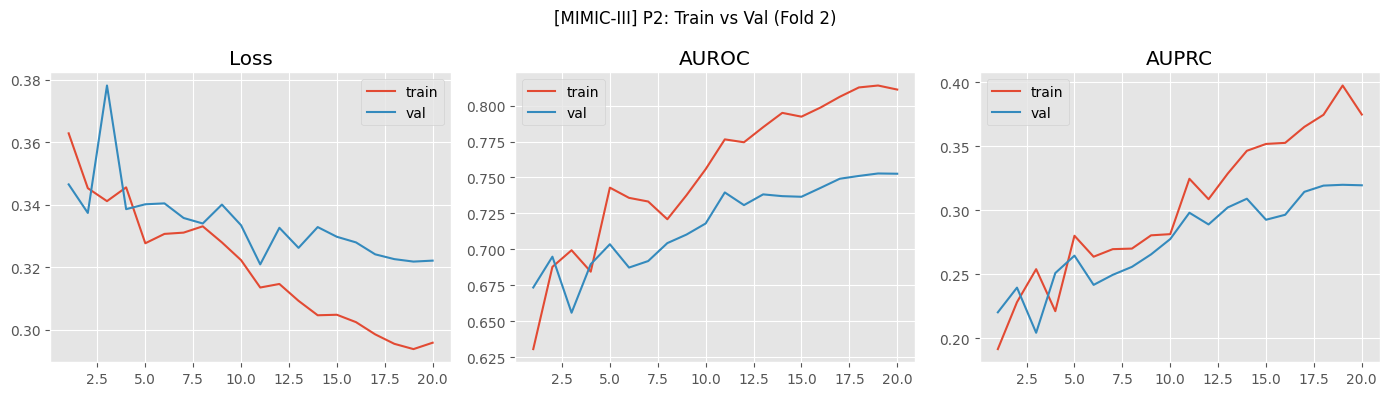

[MIMIC-III] P3 | Epoch 01 | train_loss=0.3915 val_loss=0.3511 | AUROC train/val=0.494/0.663 | AUPRC train/val=0.121/0.221
[MIMIC-III] P3 | Epoch 02 | train_loss=0.3594 val_loss=0.3458 | AUROC train/val=0.622/0.658 | AUPRC train/val=0.181/0.242
[MIMIC-III] P3 | Epoch 03 | train_loss=0.3468 val_loss=0.3624 | AUROC train/val=0.660/0.657 | AUPRC train/val=0.245/0.236
[MIMIC-III] P3 | Epoch 04 | train_loss=0.3416 val_loss=0.3416 | AUROC train/val=0.683/0.670 | AUPRC train/val=0.248/0.244
[MIMIC-III] P3 | Epoch 05 | train_loss=0.3439 val_loss=0.3456 | AUROC train/val=0.681/0.673 | AUPRC train/val=0.225/0.205
[MIMIC-III] P3 | Epoch 06 | train_loss=0.3431 val_loss=0.3463 | AUROC train/val=0.687/0.676 | AUPRC train/val=0.226/0.251
[MIMIC-III] P3 | Epoch 07 | train_loss=0.3315 val_loss=0.3494 | AUROC train/val=0.723/0.675 | AUPRC train/val=0.263/0.224
[MIMIC-III] P3 | Epoch 08 | train_loss=0.3309 val_loss=0.3456 | AUROC train/val=0.722/0.681 | AUPRC train/val=0.281/0.231
[MIMIC-III] P3 | Epoch 0

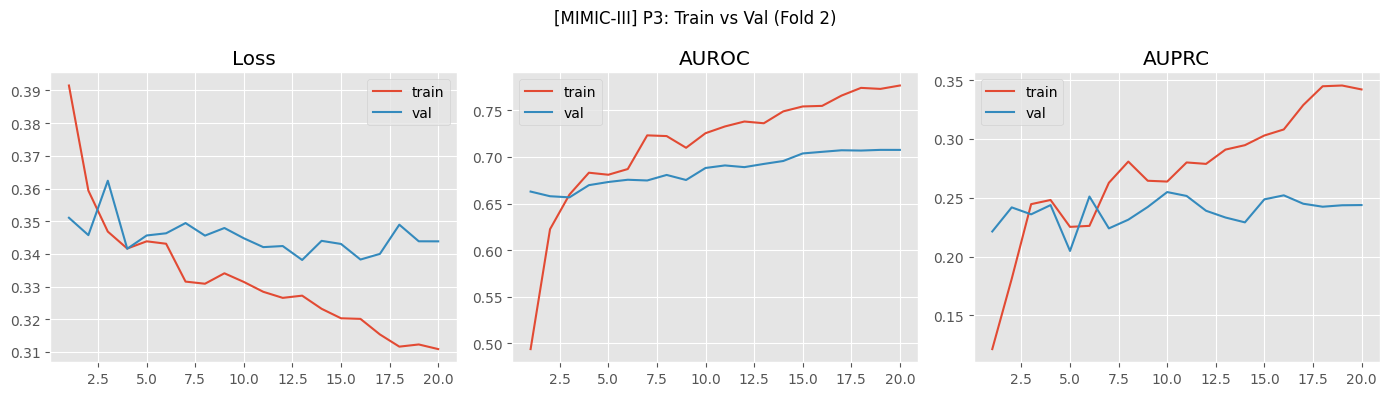

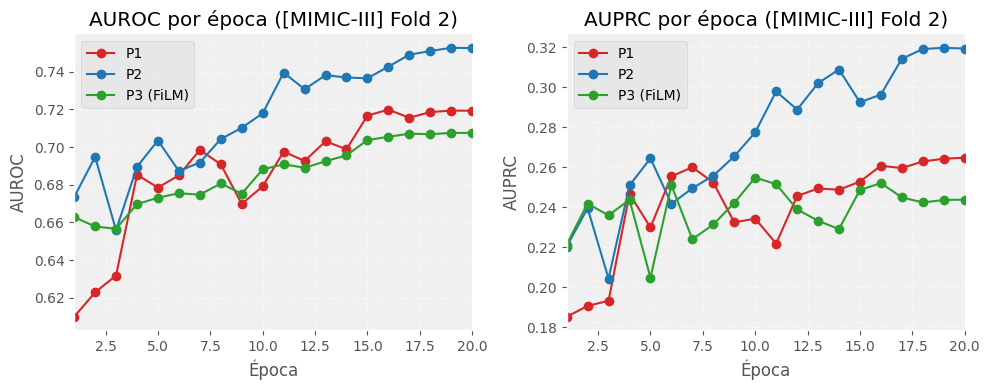

[MIMIC-III] Fold 2 | Test AUROC P1/P2/P3 = 0.755 / 0.789 / 0.720 | AUPRC P1/P2/P3 = 0.310 / 0.368 / 0.289
[MIMIC-III] === Fold 3 ===
[MIMIC-III] P1 | Epoch 01 | train_loss=0.3827 val_loss=0.3295 | AUROC train/val=0.556/0.663 | AUPRC train/val=0.144/0.182
[MIMIC-III] P1 | Epoch 02 | train_loss=0.3712 val_loss=0.3408 | AUROC train/val=0.592/0.658 | AUPRC train/val=0.168/0.203
[MIMIC-III] P1 | Epoch 03 | train_loss=0.3717 val_loss=0.3324 | AUROC train/val=0.590/0.679 | AUPRC train/val=0.164/0.191
[MIMIC-III] P1 | Epoch 04 | train_loss=0.3694 val_loss=0.3294 | AUROC train/val=0.601/0.668 | AUPRC train/val=0.167/0.202
[MIMIC-III] P1 | Epoch 05 | train_loss=0.3691 val_loss=0.3288 | AUROC train/val=0.600/0.659 | AUPRC train/val=0.174/0.184
[MIMIC-III] P1 | Epoch 06 | train_loss=0.3714 val_loss=0.3365 | AUROC train/val=0.585/0.675 | AUPRC train/val=0.164/0.194
[MIMIC-III] P1 | Epoch 07 | train_loss=0.3697 val_loss=0.3316 | AUROC train/val=0.599/0.671 | AUPRC train/val=0.165/0.200
[MIMIC-III] P

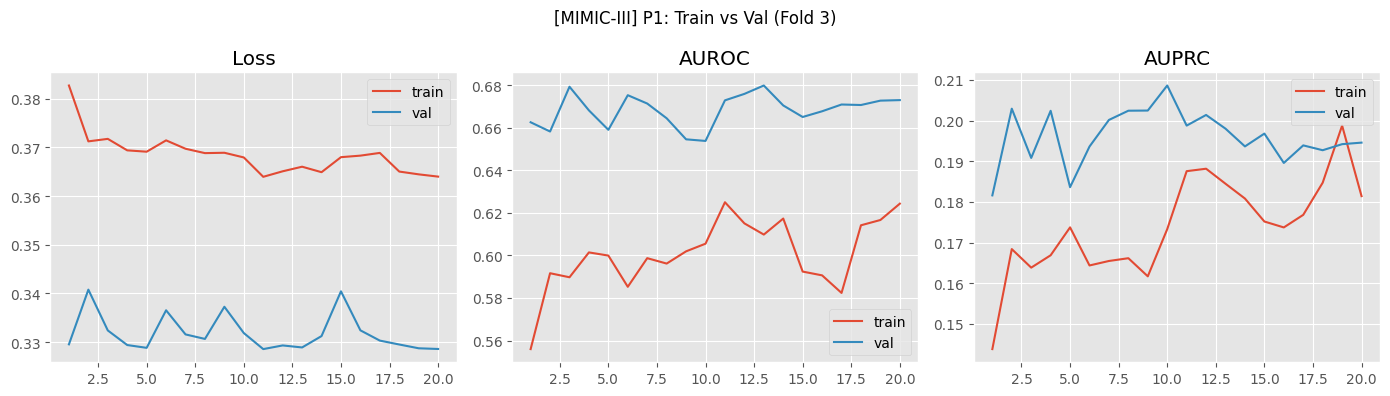

[MIMIC-III] P2 | Epoch 01 | train_loss=0.3821 val_loss=0.3298 | AUROC train/val=0.557/0.692 | AUPRC train/val=0.145/0.228
[MIMIC-III] P2 | Epoch 02 | train_loss=0.3672 val_loss=0.3253 | AUROC train/val=0.621/0.701 | AUPRC train/val=0.178/0.225
[MIMIC-III] P2 | Epoch 03 | train_loss=0.3639 val_loss=0.3235 | AUROC train/val=0.630/0.691 | AUPRC train/val=0.186/0.237
[MIMIC-III] P2 | Epoch 04 | train_loss=0.3592 val_loss=0.3229 | AUROC train/val=0.651/0.696 | AUPRC train/val=0.204/0.241
[MIMIC-III] P2 | Epoch 05 | train_loss=0.3554 val_loss=0.3375 | AUROC train/val=0.663/0.686 | AUPRC train/val=0.222/0.234
[MIMIC-III] P2 | Epoch 06 | train_loss=0.3587 val_loss=0.3304 | AUROC train/val=0.653/0.669 | AUPRC train/val=0.198/0.193
[MIMIC-III] P2 | Epoch 07 | train_loss=0.3564 val_loss=0.3193 | AUROC train/val=0.661/0.713 | AUPRC train/val=0.208/0.205
[MIMIC-III] P2 | Epoch 08 | train_loss=0.3586 val_loss=0.3232 | AUROC train/val=0.655/0.708 | AUPRC train/val=0.204/0.206
[MIMIC-III] P2 | Epoch 0

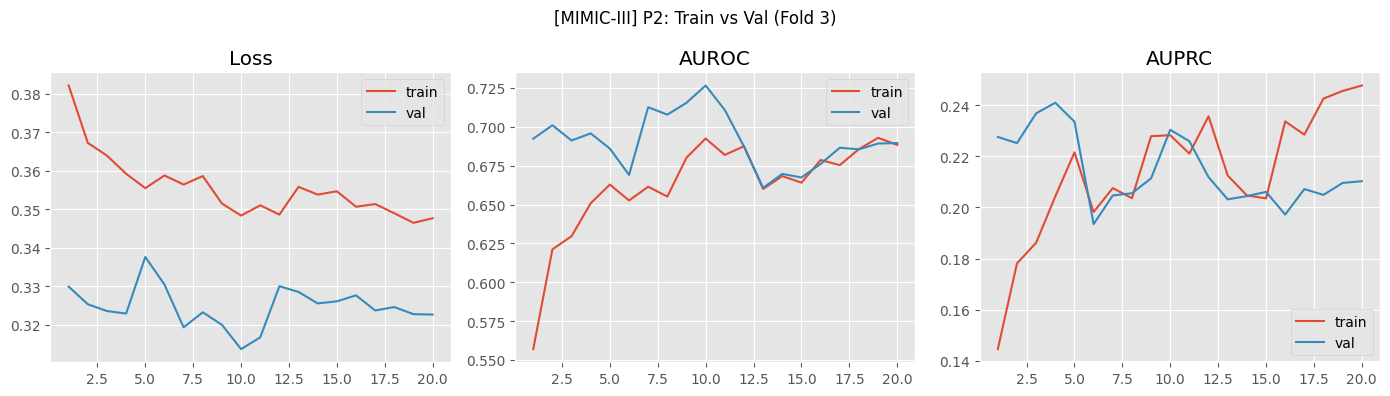

[MIMIC-III] P3 | Epoch 01 | train_loss=0.3865 val_loss=0.3244 | AUROC train/val=0.554/0.678 | AUPRC train/val=0.147/0.235
[MIMIC-III] P3 | Epoch 02 | train_loss=0.3672 val_loss=0.3419 | AUROC train/val=0.616/0.695 | AUPRC train/val=0.183/0.233
[MIMIC-III] P3 | Epoch 03 | train_loss=0.3664 val_loss=0.3318 | AUROC train/val=0.622/0.692 | AUPRC train/val=0.186/0.221
[MIMIC-III] P3 | Epoch 04 | train_loss=0.3567 val_loss=0.3193 | AUROC train/val=0.661/0.706 | AUPRC train/val=0.210/0.216
[MIMIC-III] P3 | Epoch 05 | train_loss=0.3562 val_loss=0.3179 | AUROC train/val=0.664/0.712 | AUPRC train/val=0.225/0.228
[MIMIC-III] P3 | Epoch 06 | train_loss=0.3525 val_loss=0.3360 | AUROC train/val=0.679/0.699 | AUPRC train/val=0.214/0.225
[MIMIC-III] P3 | Epoch 07 | train_loss=0.3538 val_loss=0.3214 | AUROC train/val=0.674/0.694 | AUPRC train/val=0.218/0.224
[MIMIC-III] P3 | Epoch 08 | train_loss=0.3582 val_loss=0.3296 | AUROC train/val=0.653/0.664 | AUPRC train/val=0.205/0.198
[MIMIC-III] P3 | Epoch 0

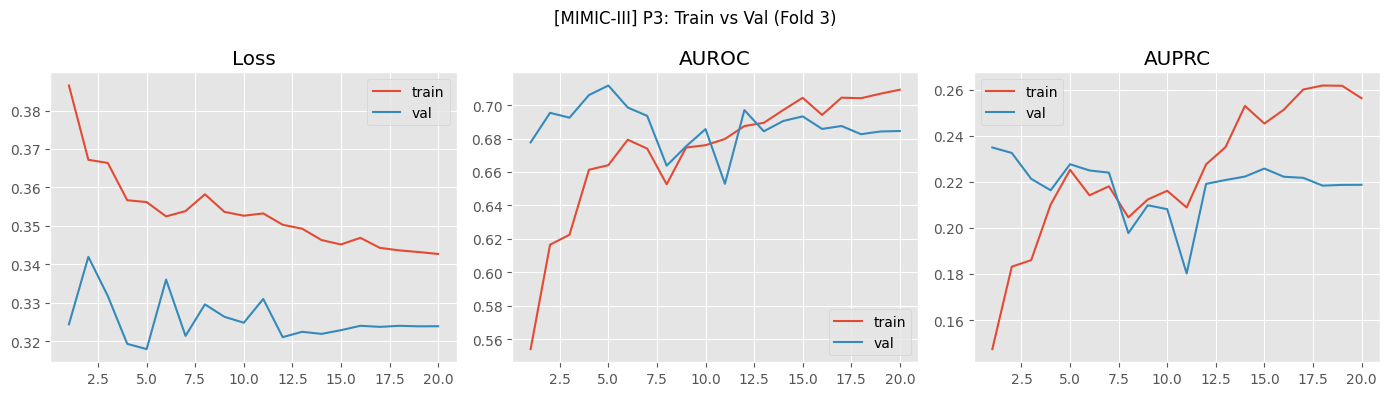

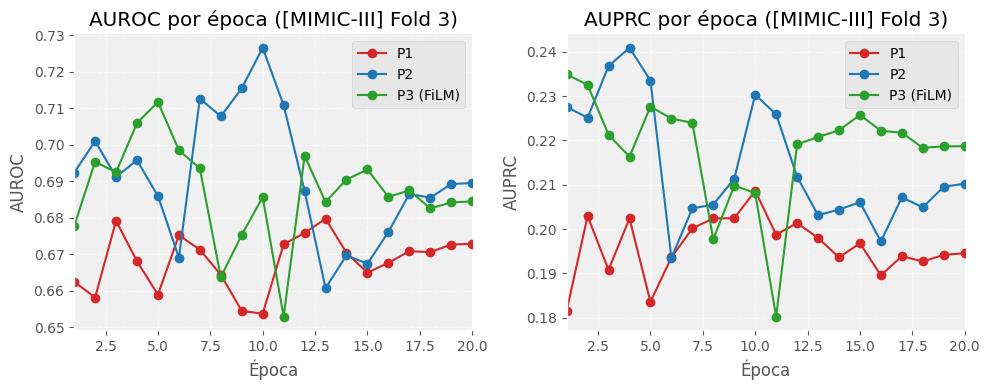

[MIMIC-III] Fold 3 | Test AUROC P1/P2/P3 = 0.595 / 0.663 / 0.658 | AUPRC P1/P2/P3 = 0.177 / 0.246 / 0.224

[MIMIC-III] === Resultados por fold (validation) ===
   fold  P1_AUROC  P1_AUPRC  P2_AUROC  P2_AUPRC  P3_AUROC  P3_AUPRC
0     1     0.617     0.190     0.666     0.236     0.716     0.275
1     2     0.719     0.265     0.753     0.319     0.708     0.244
2     3     0.673     0.195     0.690     0.210     0.684     0.219

[MIMIC-III] Promedios (validation):
fold        2.000
P1_AUROC    0.670
P1_AUPRC    0.217
P2_AUROC    0.703
P2_AUPRC    0.255
P3_AUROC    0.703
P3_AUPRC    0.246
dtype: float64


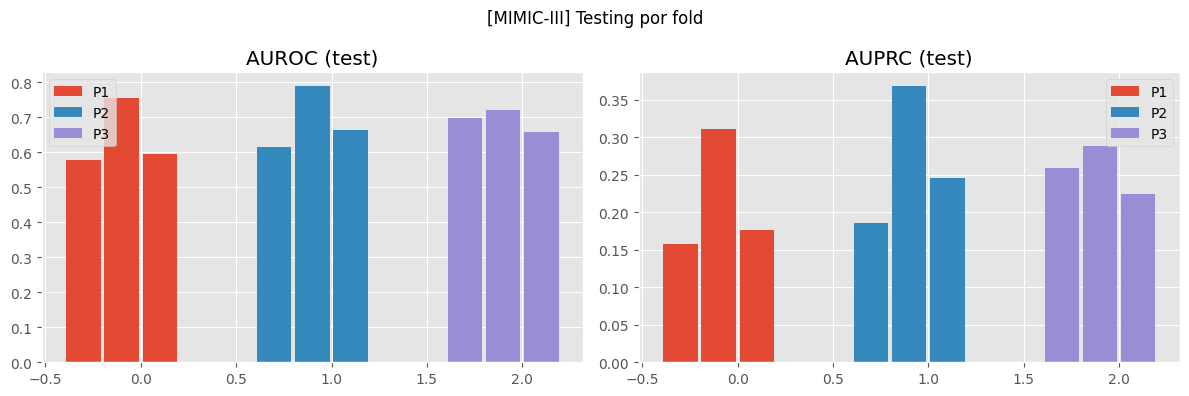

In [32]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import GroupKFold, GroupShuffleSplit
from sklearn.metrics import roc_auc_score, average_precision_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("DEVICE:", DEVICE)

D_MODEL = 128
N_HEADS = 4
N_LAYERS = 2
DROPOUT = 0.2
LR = 2e-3
WEIGHT_DECAY = 1e-4
EPOCHS = 20
GRAD_CLIP = 1.0
BATCH_TRAIN = 64
BATCH_VAL = 128
BATCH_TEST = 128

# === Estandarización por canal ===
def compute_channel_stats(X_train, M_train):
    B, L, C = X_train.shape
    means = np.zeros((C,), dtype=float)
    stds = np.ones((C,), dtype=float)
    for c in range(C):
        mask_c = M_train[..., c].astype(bool)
        vals = X_train[..., c][mask_c]
        if vals.size == 0:
            means[c] = 0.0
            stds[c] = 1.0
        else:
            means[c] = float(np.mean(vals))
            stds[c] = float(np.std(vals) + 1e-6)
    return means, stds

def standardize_by_stats(X, M, means, stds):
    X_std = (X - means[None, None, :]) / stds[None, None, :]
    X_std = np.where(M == 1.0, X_std, 0.0)
    return X_std

# === Datasets ===
class TimeDataset(Dataset):
    def __init__(self, X, T, M, y, user_ids=None):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.T = torch.tensor(T, dtype=torch.float32)
        self.M = torch.tensor(M, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        self.user_ids = user_ids if user_ids is not None else [None]*len(y)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.T[idx], self.M[idx], self.y[idx], self.user_ids[idx]

class TimeDatasetWithProfile(TimeDataset):
    def __init__(self, X, T, M, y, profiles, user_ids=None):
        super().__init__(X, T, M, y, user_ids)
        self.P = torch.tensor(profiles, dtype=torch.float32)

    def __getitem__(self, idx):
        X, T, M, y, uid = super().__getitem__(idx)
        return X, T, M, y, uid, self.P[idx]

# === mTAN + FiLM models ===
class TimeAttentionBlock(nn.Module):
    def __init__(self, d_model, n_heads, dropout=0.2):
        super().__init__()
        self.n_heads = n_heads
        self.d_model = d_model
        self.dk = d_model // n_heads

        self.Wq = nn.Linear(d_model, d_model)
        self.Wk = nn.Linear(d_model, d_model)
        self.Wv = nn.Linear(d_model, d_model)
        self.out = nn.Linear(d_model, d_model)

        self.ln1 = nn.LayerNorm(d_model)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, 4*d_model),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(4*d_model, d_model),
            nn.Dropout(dropout),
        )
        self.ln2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

        self.time_decay = nn.Parameter(torch.tensor(0.1, dtype=torch.float32))

    def forward(self, x, T, M, gamma=None, beta=None):
        B, L, d = x.size()
        Q = self.Wq(x)
        K = self.Wk(x)
        V = self.Wv(x)

        def split_heads(t):
            return t.view(B, L, self.n_heads, self.dk).transpose(1, 2)

        Qh, Kh, Vh = split_heads(Q), split_heads(K), split_heads(V)

        scores = torch.matmul(Qh, Kh.transpose(-2, -1)) / np.sqrt(self.dk)

        Ti = T.unsqueeze(1).unsqueeze(-1)
        Tj = T.unsqueeze(1).unsqueeze(-2)
        time_dist = torch.abs(Ti - Tj)
        scores = scores - self.time_decay * time_dist

        step_valid = (M.sum(dim=-1) > 0).unsqueeze(1).unsqueeze(2)
        scores = scores.masked_fill(~step_valid, float("-inf"))

        A = torch.softmax(scores, dim=-1)
        A = self.dropout(A)
        Zh = torch.matmul(A, Vh)
        Z = Zh.transpose(1, 2).contiguous().view(B, L, d)

        h_attn = self.out(Z)
        y1 = self.ln1(x + h_attn)

        if gamma is not None and beta is not None:
            y1 = y1 * gamma + beta

        f = self.ffn(y1)
        y2 = self.ln2(y1 + f)

        if gamma is not None and beta is not None:
            y2 = y2 * gamma + beta

        return y2

class MTANBackbone(nn.Module):
    def __init__(self, in_channels, d_model=128, n_layers=2, n_heads=4, dropout=0.2):
        super().__init__()
        self.input_proj = nn.Linear(in_channels, d_model)
        self.layers = nn.ModuleList([
            TimeAttentionBlock(d_model, n_heads, dropout=dropout)
            for _ in range(n_layers)
        ])
        self.d_model = d_model
        self.n_layers = n_layers

    def forward(self, X, T, M, gammas=None, betas=None):
        h = self.input_proj(X)
        for l, layer in enumerate(self.layers):
            gamma_l = None if gammas is None else gammas[:, l, :].unsqueeze(1)
            beta_l  = None if betas  is None else betas[:, l, :].unsqueeze(1)
            h = layer(h, T, M, gamma=gamma_l, beta=beta_l)
        return h

class FiLMGenerator(nn.Module):
    def __init__(self, p_dim, d_model, n_layers, hidden=64, dropout=0.1):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(p_dim, hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, 2 * n_layers * d_model)
        )
        nn.init.zeros_(self.mlp[-1].weight)
        nn.init.zeros_(self.mlp[-1].bias)
        self.d_model = d_model
        self.n_layers = n_layers

    def forward(self, P):
        B = P.size(0)
        out = self.mlp(P).view(B, 2, self.n_layers, self.d_model)
        gammas = out[:, 0, :, :] + 1.0
        betas  = out[:, 1, :, :]
        return gammas, betas

class HeadMLP(nn.Module):
    def __init__(self, d_in, d_hidden=64, dropout=0.2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_in, d_hidden),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_hidden, 1)
        )
    def forward(self, x):
        return self.net(x).squeeze(-1)

class ModelPhase1_TS(nn.Module):
    def __init__(self, in_channels, d_model=D_MODEL, n_layers=N_LAYERS,
                 n_heads=N_HEADS, dropout=DROPOUT):
        super().__init__()
        self.backbone = MTANBackbone(in_channels, d_model, n_layers, n_heads, dropout)
        self.head = HeadMLP(d_model, d_hidden=64, dropout=dropout)

    def forward(self, X, T, M):
        h = self.backbone(X, T, M, gammas=None, betas=None)
        step_valid = (M.sum(dim=-1) > 0).float()
        denom = torch.clamp(step_valid.sum(dim=1, keepdim=True), min=1.0)
        h_seq = (h * step_valid.unsqueeze(-1)).sum(dim=1) / denom
        return self.head(h_seq)

class ModelPhase2_TSProfile(nn.Module):
    def __init__(self, in_channels, p_dim, d_model=D_MODEL, n_layers=N_LAYERS,
                 n_heads=N_HEADS, dropout=DROPOUT):
        super().__init__()
        self.backbone = MTANBackbone(in_channels, d_model, n_layers, n_heads, dropout)
        self.profile_mlp = nn.Sequential(
            nn.Linear(p_dim, 64),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.head = HeadMLP(d_model + 64, d_hidden=64, dropout=dropout)

    def forward(self, X, T, M, P):
        h = self.backbone(X, T, M, gammas=None, betas=None)
        step_valid = (M.sum(dim=-1) > 0).float()
        denom = torch.clamp(step_valid.sum(dim=1, keepdim=True), min=1.0)
        h_seq = (h * step_valid.unsqueeze(-1)).sum(dim=1) / denom
        h_prof = self.profile_mlp(P)
        return self.head(torch.cat([h_seq, h_prof], dim=-1))

class ModelPhase3_FiLM(nn.Module):
    def __init__(self, in_channels, p_dim, d_model=D_MODEL, n_layers=N_LAYERS,
                 n_heads=N_HEADS, dropout=DROPOUT, film_hidden=64):
        super().__init__()
        self.backbone = MTANBackbone(in_channels, d_model, n_layers, n_heads, dropout)
        self.film = FiLMGenerator(p_dim, d_model, n_layers, hidden=film_hidden, dropout=0.1)
        self.head = HeadMLP(d_model, d_hidden=64, dropout=dropout)

    def forward(self, X, T, M, P):
        gammas, betas = self.film(P)
        h = self.backbone(X, T, M, gammas=gammas, betas=betas)
        step_valid = (M.sum(dim=-1) > 0).float()
        denom = torch.clamp(step_valid.sum(dim=1, keepdim=True), min=1.0)
        h_seq = (h * step_valid.unsqueeze(-1)).sum(dim=1) / denom
        return self.head(h_seq)

# === Entrenamiento / evaluación ===
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0.0
    logits_all, targets_all = [], []

    for batch in loader:
        optimizer.zero_grad()

        if len(batch) == 5:
            X, T, M, y, _ = batch
            X, T, M, y = X.to(DEVICE), T.to(DEVICE), M.to(DEVICE), y.to(DEVICE)
            logits = model(X, T, M)
        else:
            X, T, M, y, _, P = batch
            X, T, M, y, P = X.to(DEVICE), T.to(DEVICE), M.to(DEVICE), y.to(DEVICE), P.to(DEVICE)
            logits = model(X, T, M, P)

        loss = criterion(logits, y)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
        optimizer.step()

        total_loss += loss.item() * X.size(0)
        logits_all.append(logits.detach().cpu().numpy())
        targets_all.append(y.detach().cpu().numpy())

    yhat = np.concatenate(logits_all)
    yt = np.concatenate(targets_all)

    try:
        auroc = roc_auc_score(yt, yhat)
    except Exception:
        auroc = np.nan
    try:
        auprc = average_precision_score(yt, yhat)
    except Exception:
        auprc = np.nan

    return total_loss / len(yt), auroc, auprc

@torch.no_grad()
def eval_one_epoch(model, loader, criterion):
    model.eval()
    total_loss = 0.0
    logits_all, targets_all = [], []

    for batch in loader:
        if len(batch) == 5:
            X, T, M, y, _ = batch
            X, T, M, y = X.to(DEVICE), T.to(DEVICE), M.to(DEVICE), y.to(DEVICE)
            logits = model(X, T, M)
        else:
            X, T, M, y, _, P = batch
            X, T, M, y, P = X.to(DEVICE), T.to(DEVICE), M.to(DEVICE), y.to(DEVICE), P.to(DEVICE)
            logits = model(X, T, M, P)

        loss = criterion(logits, y)
        total_loss += loss.item() * X.size(0)
        logits_all.append(logits.detach().cpu().numpy())
        targets_all.append(y.detach().cpu().numpy())

    yhat = np.concatenate(logits_all)
    yt = np.concatenate(targets_all)

    try:
        auroc = roc_auc_score(yt, yhat)
    except Exception:
        auroc = np.nan
    try:
        auprc = average_precision_score(yt, yhat)
    except Exception:
        auprc = np.nan

    return total_loss / len(yt), auroc, auprc

def run_phase(phase_name, train_loader, val_loader, in_channels, p_dim=None, label_prefix=""):
    if phase_name == "P1":
        model = ModelPhase1_TS(in_channels).to(DEVICE)
    elif phase_name == "P2":
        assert p_dim is not None
        model = ModelPhase2_TSProfile(in_channels, p_dim).to(DEVICE)
    elif phase_name == "P3":
        assert p_dim is not None
        model = ModelPhase3_FiLM(in_channels, p_dim).to(DEVICE)
    else:
        raise ValueError("phase_name must be P1, P2 or P3")

    optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
    criterion = nn.BCEWithLogitsLoss()

    history = {
        "train_auroc": [], "train_auprc": [],
        "val_auroc": [], "val_auprc": [],
        "train_loss": [], "val_loss": []
    }

    best_val = -np.inf
    best_state = None

    for ep in range(1, EPOCHS + 1):
        tl, tr_auc, tr_pr = train_one_epoch(model, train_loader, optimizer, criterion)
        vl, va_auc, va_pr = eval_one_epoch(model, val_loader, criterion)
        scheduler.step()

        history["train_loss"].append(tl)
        history["val_loss"].append(vl)
        history["train_auroc"].append(tr_auc)
        history["val_auroc"].append(va_auc)
        history["train_auprc"].append(tr_pr)
        history["val_auprc"].append(va_pr)

        score = np.nanmean([va_auc, va_pr])
        if score > best_val:
            best_val = score
            best_state = {"model": model.state_dict()}

        print(f"{label_prefix} {phase_name} | Epoch {ep:02d} | "
              f"train_loss={tl:.4f} val_loss={vl:.4f} | "
              f"AUROC train/val={tr_auc:.3f}/{va_auc:.3f} | "
              f"AUPRC train/val={tr_pr:.3f}/{va_pr:.3f}")

    if best_state is not None:
        model.load_state_dict(best_state["model"])
    return model, history

# === Gráficas ===
def plot_history(history, title):
    epochs = range(1, len(history["train_loss"]) + 1)
    fig, axs = plt.subplots(1, 3, figsize=(14, 4))

    axs[0].plot(epochs, history["train_loss"], label="train")
    axs[0].plot(epochs, history["val_loss"], label="val")
    axs[0].set_title("Loss"); axs[0].legend()

    axs[1].plot(epochs, history["train_auroc"], label="train")
    axs[1].plot(epochs, history["val_auroc"], label="val")
    axs[1].set_title("AUROC"); axs[1].legend()

    axs[2].plot(epochs, history["train_auprc"], label="train")
    axs[2].plot(epochs, history["val_auprc"], label="val")
    axs[2].set_title("AUPRC"); axs[2].legend()

    fig.suptitle(title)
    plt.tight_layout()
    return fig

def plot_testing_bars(test_metrics, title):
    phases = ["P1", "P2", "P3"]
    n_folds = max(len(test_metrics[p]) for p in phases)
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    for i, p in enumerate(phases):
        aurocs = [m[0] for m in test_metrics[p]]
        xs = [i + (j - n_folds / 2) * 0.2 for j in range(len(aurocs))]
        axs[0].bar(xs, aurocs, width=0.18, label=p)
    axs[0].set_title("AUROC (test)"); axs[0].legend()

    for i, p in enumerate(phases):
        auprcs = [m[1] for m in test_metrics[p]]
        xs = [i + (j - n_folds / 2) * 0.2 for j in range(len(auprcs))]
        axs[1].bar(xs, auprcs, width=0.18, label=p)
    axs[1].set_title("AUPRC (test)"); axs[1].legend()

    fig.suptitle(title)
    plt.tight_layout()
    return fig

def plot_auroc_auprc_by_epoch_phases(
    hist_p1,
    hist_p2,
    hist_p3,
    cohort_label="cohorte X",
    use_validation=True,
    figsize=(10, 4),
    save_path=None
):
    """
    Dibuja dos subplots:
      - Izquierda: AUROC por época para P1, P2, P3
      - Derecha:  AUPRC por época para P1, P2, P3

    hist_p1, hist_p2, hist_p3: dicts devueltos por run_phase.
    """

    metric_suffix = "val" if use_validation else "train"
    auroc_key = f"{metric_suffix}_auroc"
    auprc_key = f"{metric_suffix}_auprc"

    import numpy as np
    epochs = np.arange(1, len(hist_p1[auroc_key]) + 1)

    auroc_p1 = np.array(hist_p1[auroc_key])
    auroc_p2 = np.array(hist_p2[auroc_key])
    auroc_p3 = np.array(hist_p3[auroc_key])

    auprc_p1 = np.array(hist_p1[auprc_key])
    auprc_p2 = np.array(hist_p2[auprc_key])
    auprc_p3 = np.array(hist_p3[auprc_key])

    plt.style.use("ggplot")
    fig, axes = plt.subplots(1, 2, figsize=figsize)

    color_p1 = "#d62728"  # rojo
    color_p2 = "#1f77b4"  # azul
    color_p3 = "#2ca02c"  # verde

    # ---------- AUROC ----------
    ax = axes[0]
    ax.plot(epochs, auroc_p1, label="P1", color=color_p1, marker="o")
    ax.plot(epochs, auroc_p2, label="P2", color=color_p2, marker="o")
    ax.plot(epochs, auroc_p3, label="P3 (FiLM)", color=color_p3, marker="o")

    ax.set_title(f"AUROC por época ({cohort_label})")
    ax.set_xlabel("Época")
    ax.set_ylabel("AUROC")
    ax.grid(True, linestyle="--", alpha=0.5)
    ax.set_xlim(1, len(epochs))
    ax.legend(loc="best")

    # ---------- AUPRC ----------
    ax = axes[1]
    ax.plot(epochs, auprc_p1, label="P1", color=color_p1, marker="o")
    ax.plot(epochs, auprc_p2, label="P2", color=color_p2, marker="o")
    ax.plot(epochs, auprc_p3, label="P3 (FiLM)", color=color_p3, marker="o")

    ax.set_title(f"AUPRC por época ({cohort_label})")
    ax.set_xlabel("Época")
    ax.set_ylabel("AUPRC")
    ax.grid(True, linestyle="--", alpha=0.5)
    ax.set_xlim(1, len(epochs))
    ax.legend(loc="best")

    # Opcional: retocar estilo de axes para parecerse más al paper
    for ax in axes:
        ax.set_facecolor("#f0f0f0")
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)

    fig.tight_layout()

    if save_path is not None:
        fig.savefig(save_path, dpi=300, bbox_inches="tight")

    return fig, axes


# === Orquestación ===
def run_mimic_pipeline(X_all, T_all, M_all, y_all, user_ids_all, P_all,
                       n_splits_cv=3, test_size=0.2, label_prefix="[MIMIC]"):
    has_profiles = P_all is not None
    p_dim = None if not has_profiles else P_all.shape[1]

    groups_by_instance = np.array(user_ids_all)
    gss = GroupShuffleSplit(n_splits=1, test_size=test_size, random_state=SEED)
    trainval_idx, test_idx = next(gss.split(X_all, y_all, groups=groups_by_instance))

    users_tv = [user_ids_all[i] for i in trainval_idx]
    users_te = [user_ids_all[i] for i in test_idx]

    print(f"{label_prefix} Train/Val instancias: {len(trainval_idx)} | "
          f"Test instancias: {len(test_idx)} | "
          f"Usuarios únicos TV: {len(set(users_tv))} | "
          f"Usuarios únicos Test: {len(set(users_te))}")

    X_tv, T_tv, M_tv, y_tv = X_all[trainval_idx], T_all[trainval_idx], M_all[trainval_idx], y_all[trainval_idx]
    X_te, T_te, M_te, y_te = X_all[test_idx], T_all[test_idx], M_all[test_idx], y_all[test_idx]
    if has_profiles:
        P_tv, P_te = P_all[trainval_idx], P_all[test_idx]
    else:
        P_tv = P_te = None

    gkf = GroupKFold(n_splits=n_splits_cv)

    results_val = []
    test_metrics = {"P1": [], "P2": [], "P3": []}

    fold_counter = 0
    in_channels = X_all.shape[2]

    for tr_idx_rel, va_idx_rel in gkf.split(X_tv, y_tv, groups=np.array(users_tv)):
        fold_counter += 1
        print(f"{label_prefix} === Fold {fold_counter} ===")

        X_tr, T_tr, M_tr, y_tr = X_tv[tr_idx_rel], T_tv[tr_idx_rel], M_tv[tr_idx_rel], y_tv[tr_idx_rel]
        X_va, T_va, M_va, y_va = X_tv[va_idx_rel], T_tv[va_idx_rel], M_tv[va_idx_rel], y_tv[va_idx_rel]
        u_tr = [users_tv[i] for i in tr_idx_rel]
        u_va = [users_tv[i] for i in va_idx_rel]

        if has_profiles:
            P_tr, P_va = P_tv[tr_idx_rel], P_tv[va_idx_rel]

        means, stds = compute_channel_stats(X_tr, M_tr)
        X_tr_std = standardize_by_stats(X_tr, M_tr, means, stds)
        X_va_std = standardize_by_stats(X_va, M_va, means, stds)

        ds_tr_p1 = TimeDataset(X_tr_std, T_tr, M_tr, y_tr, user_ids=u_tr)
        ds_va_p1 = TimeDataset(X_va_std, T_va, M_va, y_va, user_ids=u_va)
        dl_tr_p1 = DataLoader(ds_tr_p1, batch_size=BATCH_TRAIN, shuffle=True, drop_last=False)
        dl_va_p1 = DataLoader(ds_va_p1, batch_size=BATCH_VAL, shuffle=False, drop_last=False)

        if has_profiles:
            ds_tr_p2 = TimeDatasetWithProfile(X_tr_std, T_tr, M_tr, y_tr, profiles=P_tr, user_ids=u_tr)
            ds_va_p2 = TimeDatasetWithProfile(X_va_std, T_va, M_va, y_va, profiles=P_va, user_ids=u_va)
            dl_tr_p2 = DataLoader(ds_tr_p2, batch_size=BATCH_TRAIN, shuffle=True, drop_last=False)
            dl_va_p2 = DataLoader(ds_va_p2, batch_size=BATCH_VAL, shuffle=False, drop_last=False)

            dl_tr_p3 = dl_tr_p2
            dl_va_p3 = dl_va_p2

        model_p1, hist_p1 = run_phase("P1", dl_tr_p1, dl_va_p1, in_channels, label_prefix=label_prefix)
        plot_history(hist_p1, title=f"{label_prefix} P1: Train vs Val (Fold {fold_counter})")
        plt.show()

        if has_profiles:
            model_p2, hist_p2 = run_phase("P2", dl_tr_p2, dl_va_p2, in_channels, p_dim=p_dim, label_prefix=label_prefix)
            plot_history(hist_p2, title=f"{label_prefix} P2: Train vs Val (Fold {fold_counter})")
            plt.show()

            model_p3, hist_p3 = run_phase("P3", dl_tr_p3, dl_va_p3, in_channels, p_dim=p_dim, label_prefix=label_prefix)
            plot_history(hist_p3, title=f"{label_prefix} P3: Train vs Val (Fold {fold_counter})")
            plt.show()

            # === NUEVA FIGURA TIPO FIGURE 5.2 / 5.3 ===
            fig_phases, axes_phases = plot_auroc_auprc_by_epoch_phases(
                hist_p1,
                hist_p2,
                hist_p3,
                cohort_label=f"{label_prefix} Fold {fold_counter}",
                use_validation=True,     # curvas de validación (como en el paper)
                figsize=(10, 4),
                # opcional: guarda en disco, por ejemplo por fold:
                # save_path=f"mimic_phases_fold{fold_counter}.png"
            )
            plt.show()

        vl_p1, va_auc_p1, va_pr_p1 = eval_one_epoch(model_p1, dl_va_p1, nn.BCEWithLogitsLoss())

        if has_profiles:
            vl_p2, va_auc_p2, va_pr_p2 = eval_one_epoch(model_p2, dl_va_p2, nn.BCEWithLogitsLoss())
            vl_p3, va_auc_p3, va_pr_p3 = eval_one_epoch(model_p3, dl_va_p3, nn.BCEWithLogitsLoss())
        else:
            va_auc_p2 = va_pr_p2 = np.nan
            va_auc_p3 = va_pr_p3 = np.nan

        results_val.append({
            "fold": fold_counter,
            "P1_AUROC": va_auc_p1, "P1_AUPRC": va_pr_p1,
            "P2_AUROC": va_auc_p2, "P2_AUPRC": va_pr_p2,
            "P3_AUROC": va_auc_p3, "P3_AUPRC": va_pr_p3,
        })

        X_te_std = standardize_by_stats(X_te, M_te, means, stds)
        ds_te_p1 = TimeDataset(X_te_std, T_te, M_te, y_te, user_ids=users_te)
        dl_te_p1 = DataLoader(ds_te_p1, batch_size=BATCH_TEST, shuffle=False, drop_last=False)

        _, te_auc_p1, te_pr_p1 = eval_one_epoch(model_p1, dl_te_p1, nn.BCEWithLogitsLoss())
        test_metrics["P1"].append((te_auc_p1, te_pr_p1))

        if has_profiles:
            ds_te_p2 = TimeDatasetWithProfile(X_te_std, T_te, M_te, y_te, profiles=P_te, user_ids=users_te)
            dl_te_p2 = DataLoader(ds_te_p2, batch_size=BATCH_TEST, shuffle=False, drop_last=False)

            _, te_auc_p2, te_pr_p2 = eval_one_epoch(model_p2, dl_te_p2, nn.BCEWithLogitsLoss())
            _, te_auc_p3, te_pr_p3 = eval_one_epoch(model_p3, dl_te_p2, nn.BCEWithLogitsLoss())

            test_metrics["P2"].append((te_auc_p2, te_pr_p2))
            test_metrics["P3"].append((te_auc_p3, te_pr_p3))

            print(f"{label_prefix} Fold {fold_counter} | Test AUROC P1/P2/P3 = "
                  f"{te_auc_p1:.3f} / {te_auc_p2:.3f} / {te_auc_p3:.3f} | "
                  f"AUPRC P1/P2/P3 = {te_pr_p1:.3f} / {te_pr_p2:.3f} / {te_pr_p3:.3f}")
        else:
            print(f"{label_prefix} Fold {fold_counter} | Test AUROC P1 = {te_auc_p1:.3f} | "
                  f"AUPRC P1 = {te_pr_p1:.3f}")

    res_df = pd.DataFrame(results_val)
    print(f"\n{label_prefix} === Resultados por fold (validation) ===")
    print(res_df.round(3))
    print(f"\n{label_prefix} Promedios (validation):")
    print(res_df.mean(numeric_only=True).round(3))

    if any(len(v) > 0 for v in test_metrics.values()):
        plot_testing_bars(test_metrics, title=f"{label_prefix} Testing por fold")
        plt.show()

    return res_df, test_metrics

# === Ejecutar pipeline ===
res_val, test_metrics = run_mimic_pipeline(
    X_all, T_all, M_all, y_all, user_ids_all, P_all,
    n_splits_cv=3,
    test_size=0.2,
    label_prefix="[MIMIC-III]"
)

>>> Llamando a load_mimic_glucose_hr...
[load_mimic_glucose_hr] Cargando desde: /home/gmartinez/Tesis/Datasets/MIMIC-III/mimic_mtan_glucose_hr_7d.pkl
[load_mimic_glucose_hr] example numbers: 9240
[load_mimic_glucose_hr] Longitudes fusionadas únicas: [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 62, 63, 64, 67]
[load_mimic_glucose_hr] Longitud máxima L_max: 67
[load_mimic_glucose_hr] Shapes finales:
  X_all: (9240, 67, 2)
  T_all: (9240, 67)
  M_all: (9240, 67, 2)
  y_all: (9240,)
  P_all: (9240, 65)
  user_ids_all: (9240,) <class 'str'>
  Nº context_feature_names: 65

L_MAX: 67 in_channels: 2 p_dim: 65
DEVICE: cuda
MIMIC-III Train/Val instances: 7392 | Test instances: 1848 | TV users: 7392 | Test users: 1848
MIMIC-III === Fold 1 ===
MIMIC-III P1 | Epoch 01 | train_loss=0.3849 val_loss=0.3897 | AUROC train/val=0.539/0.615

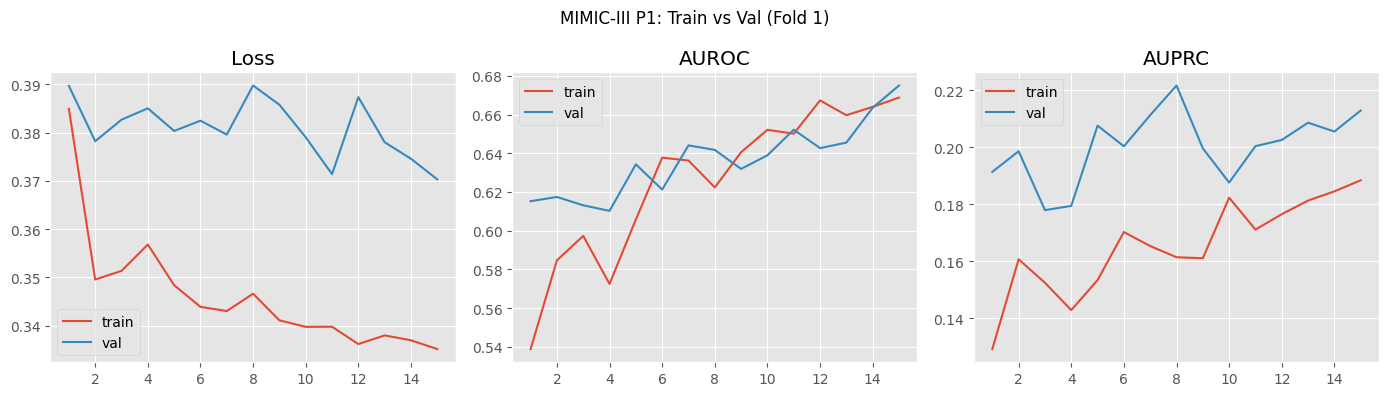

MIMIC-III P2 | Epoch 01 | train_loss=0.3910 val_loss=0.3904 | AUROC train/val=0.495/0.584 | AUPRC train/val=0.113/0.175 | best_val_AUPRC=0.175 | patience=0/7
MIMIC-III P2 | Epoch 02 | train_loss=0.3604 val_loss=0.3754 | AUROC train/val=0.555/0.629 | AUPRC train/val=0.141/0.204 | best_val_AUPRC=0.204 | patience=0/7
MIMIC-III P2 | Epoch 03 | train_loss=0.3489 val_loss=0.3808 | AUROC train/val=0.616/0.659 | AUPRC train/val=0.162/0.232 | best_val_AUPRC=0.232 | patience=0/7
MIMIC-III P2 | Epoch 04 | train_loss=0.3471 val_loss=0.3731 | AUROC train/val=0.622/0.660 | AUPRC train/val=0.164/0.245 | best_val_AUPRC=0.245 | patience=0/7
MIMIC-III P2 | Epoch 05 | train_loss=0.3453 val_loss=0.3749 | AUROC train/val=0.633/0.667 | AUPRC train/val=0.171/0.249 | best_val_AUPRC=0.249 | patience=0/7
MIMIC-III P2 | Epoch 06 | train_loss=0.3450 val_loss=0.3695 | AUROC train/val=0.629/0.671 | AUPRC train/val=0.162/0.238 | best_val_AUPRC=0.249 | patience=1/7
MIMIC-III P2 | Epoch 07 | train_loss=0.3414 val_loss

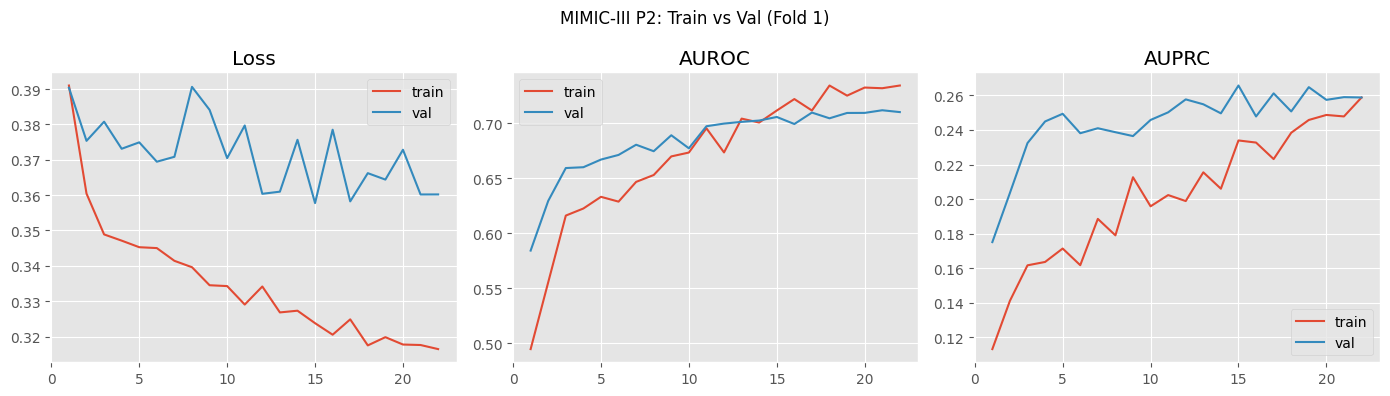

MIMIC-III P3 | Epoch 01 | train_loss=0.3755 val_loss=0.3747 | AUROC train/val=0.506/0.636 | AUPRC train/val=0.115/0.212 | best_val_AUPRC=0.212 | patience=0/7
MIMIC-III P3 | Epoch 02 | train_loss=0.3500 val_loss=0.3791 | AUROC train/val=0.604/0.651 | AUPRC train/val=0.168/0.237 | best_val_AUPRC=0.237 | patience=0/7
MIMIC-III P3 | Epoch 03 | train_loss=0.3462 val_loss=0.3747 | AUROC train/val=0.625/0.669 | AUPRC train/val=0.168/0.249 | best_val_AUPRC=0.249 | patience=0/7
MIMIC-III P3 | Epoch 04 | train_loss=0.3412 val_loss=0.3747 | AUROC train/val=0.652/0.693 | AUPRC train/val=0.184/0.267 | best_val_AUPRC=0.267 | patience=0/7
MIMIC-III P3 | Epoch 05 | train_loss=0.3338 val_loss=0.3586 | AUROC train/val=0.678/0.699 | AUPRC train/val=0.206/0.267 | best_val_AUPRC=0.267 | patience=1/7
MIMIC-III P3 | Epoch 06 | train_loss=0.3316 val_loss=0.3801 | AUROC train/val=0.686/0.686 | AUPRC train/val=0.207/0.261 | best_val_AUPRC=0.267 | patience=2/7
MIMIC-III P3 | Epoch 07 | train_loss=0.3297 val_loss

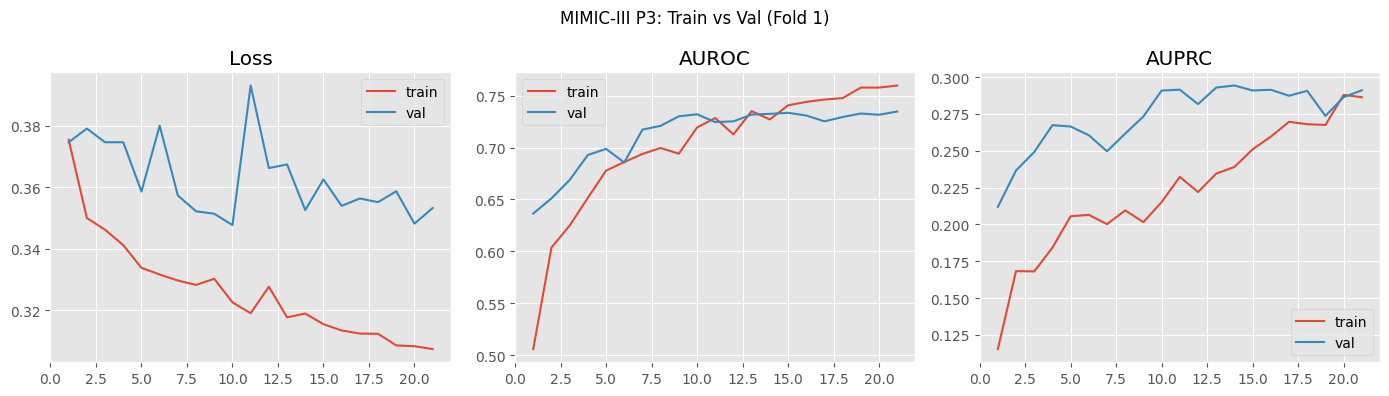

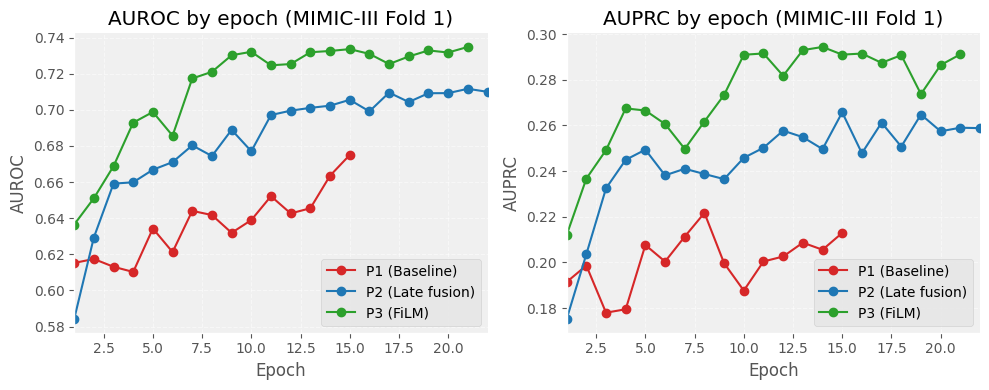

MIMIC-III Fold 1 | Test AUROC P1/P2/P3 = 0.634 / 0.676 / 0.709 | AUPRC P1/P2/P3 = 0.191 / 0.238 / 0.264
MIMIC-III === Fold 2 ===
MIMIC-III P1 | Epoch 01 | train_loss=0.4159 val_loss=0.3587 | AUROC train/val=0.544/0.642 | AUPRC train/val=0.126/0.182 | best_val_AUPRC=0.182 | patience=0/7
MIMIC-III P1 | Epoch 02 | train_loss=0.3492 val_loss=0.3493 | AUROC train/val=0.657/0.652 | AUPRC train/val=0.233/0.203 | best_val_AUPRC=0.203 | patience=0/7
MIMIC-III P1 | Epoch 03 | train_loss=0.3423 val_loss=0.3493 | AUROC train/val=0.692/0.660 | AUPRC train/val=0.247/0.204 | best_val_AUPRC=0.204 | patience=0/7
MIMIC-III P1 | Epoch 04 | train_loss=0.3421 val_loss=0.3553 | AUROC train/val=0.696/0.648 | AUPRC train/val=0.238/0.203 | best_val_AUPRC=0.204 | patience=1/7
MIMIC-III P1 | Epoch 05 | train_loss=0.3335 val_loss=0.3519 | AUROC train/val=0.720/0.683 | AUPRC train/val=0.286/0.235 | best_val_AUPRC=0.235 | patience=0/7
MIMIC-III P1 | Epoch 06 | train_loss=0.3235 val_loss=0.3487 | AUROC train/val=0.7

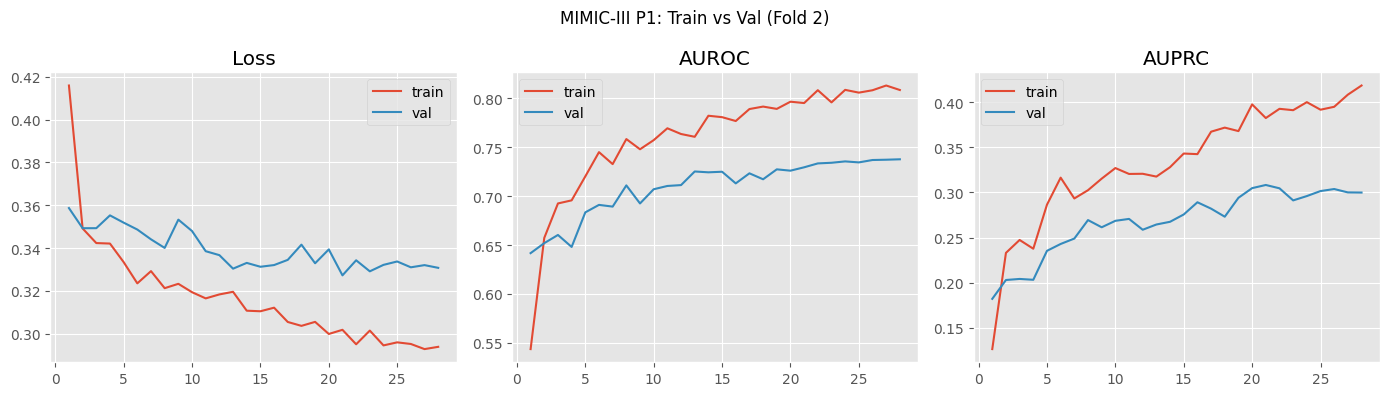

MIMIC-III P2 | Epoch 01 | train_loss=0.4101 val_loss=0.3579 | AUROC train/val=0.538/0.574 | AUPRC train/val=0.134/0.168 | best_val_AUPRC=0.168 | patience=0/7
MIMIC-III P2 | Epoch 02 | train_loss=0.3651 val_loss=0.3661 | AUROC train/val=0.604/0.625 | AUPRC train/val=0.183/0.185 | best_val_AUPRC=0.185 | patience=0/7
MIMIC-III P2 | Epoch 03 | train_loss=0.3568 val_loss=0.3502 | AUROC train/val=0.646/0.647 | AUPRC train/val=0.209/0.198 | best_val_AUPRC=0.198 | patience=0/7
MIMIC-III P2 | Epoch 04 | train_loss=0.3385 val_loss=0.3380 | AUROC train/val=0.705/0.691 | AUPRC train/val=0.264/0.241 | best_val_AUPRC=0.241 | patience=0/7
MIMIC-III P2 | Epoch 05 | train_loss=0.3413 val_loss=0.3339 | AUROC train/val=0.696/0.699 | AUPRC train/val=0.263/0.256 | best_val_AUPRC=0.256 | patience=0/7
MIMIC-III P2 | Epoch 06 | train_loss=0.3314 val_loss=0.3354 | AUROC train/val=0.721/0.704 | AUPRC train/val=0.281/0.244 | best_val_AUPRC=0.256 | patience=1/7
MIMIC-III P2 | Epoch 07 | train_loss=0.3277 val_loss

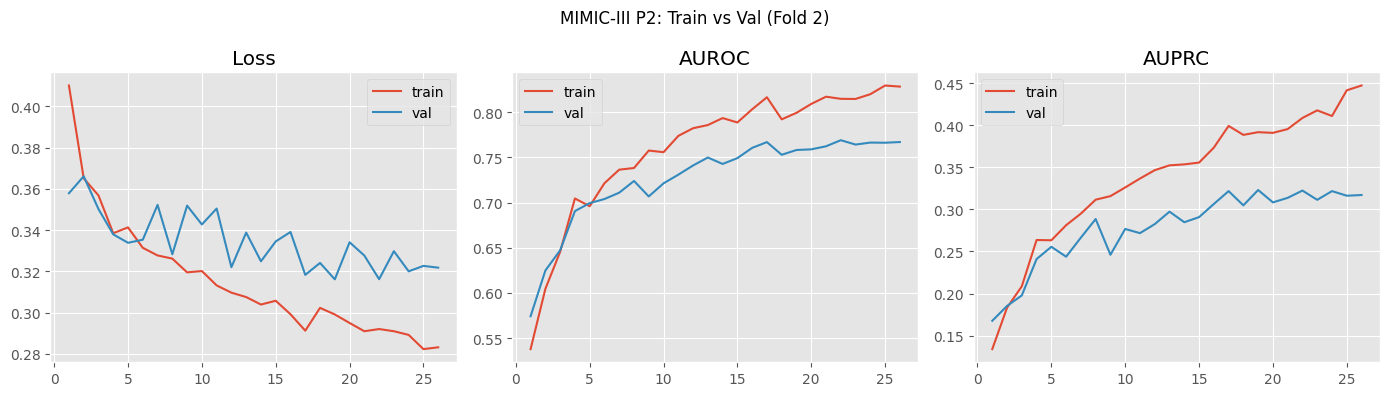

MIMIC-III P3 | Epoch 01 | train_loss=0.3718 val_loss=0.3467 | AUROC train/val=0.585/0.652 | AUPRC train/val=0.157/0.202 | best_val_AUPRC=0.202 | patience=0/7
MIMIC-III P3 | Epoch 02 | train_loss=0.3411 val_loss=0.3404 | AUROC train/val=0.695/0.686 | AUPRC train/val=0.249/0.224 | best_val_AUPRC=0.224 | patience=0/7
MIMIC-III P3 | Epoch 03 | train_loss=0.3355 val_loss=0.3834 | AUROC train/val=0.715/0.680 | AUPRC train/val=0.286/0.234 | best_val_AUPRC=0.234 | patience=0/7
MIMIC-III P3 | Epoch 04 | train_loss=0.3313 val_loss=0.3628 | AUROC train/val=0.729/0.711 | AUPRC train/val=0.281/0.266 | best_val_AUPRC=0.266 | patience=0/7
MIMIC-III P3 | Epoch 05 | train_loss=0.3187 val_loss=0.3349 | AUROC train/val=0.764/0.731 | AUPRC train/val=0.325/0.293 | best_val_AUPRC=0.293 | patience=0/7
MIMIC-III P3 | Epoch 06 | train_loss=0.3137 val_loss=0.3277 | AUROC train/val=0.772/0.728 | AUPRC train/val=0.350/0.280 | best_val_AUPRC=0.293 | patience=1/7
MIMIC-III P3 | Epoch 07 | train_loss=0.3149 val_loss

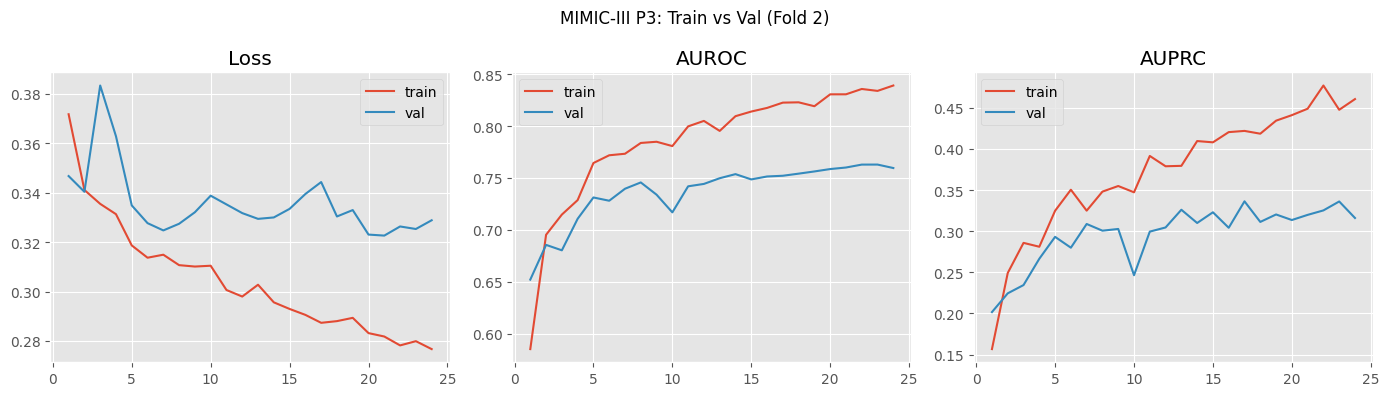

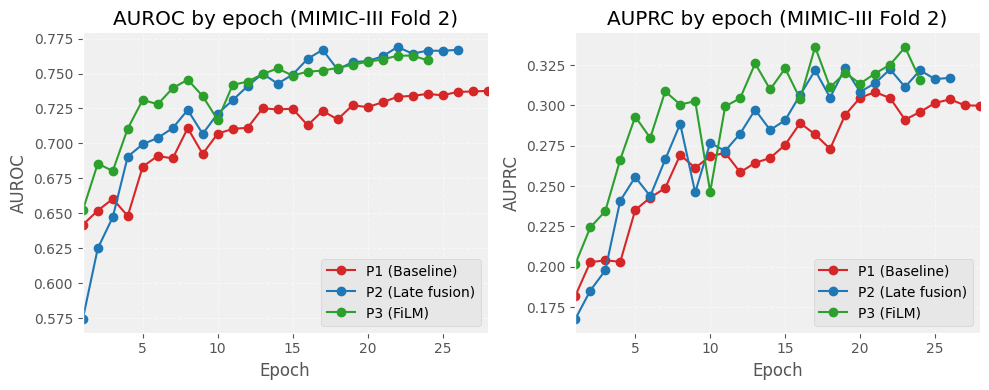

MIMIC-III Fold 2 | Test AUROC P1/P2/P3 = 0.769 / 0.784 / 0.794 | AUPRC P1/P2/P3 = 0.369 / 0.371 / 0.386
MIMIC-III === Fold 3 ===
MIMIC-III P1 | Epoch 01 | train_loss=0.4009 val_loss=0.3382 | AUROC train/val=0.546/0.652 | AUPRC train/val=0.138/0.182 | best_val_AUPRC=0.182 | patience=0/7
MIMIC-III P1 | Epoch 02 | train_loss=0.3737 val_loss=0.3384 | AUROC train/val=0.568/0.642 | AUPRC train/val=0.160/0.179 | best_val_AUPRC=0.182 | patience=1/7
MIMIC-III P1 | Epoch 03 | train_loss=0.3742 val_loss=0.3424 | AUROC train/val=0.572/0.665 | AUPRC train/val=0.160/0.194 | best_val_AUPRC=0.194 | patience=0/7
MIMIC-III P1 | Epoch 04 | train_loss=0.3735 val_loss=0.3287 | AUROC train/val=0.584/0.682 | AUPRC train/val=0.155/0.198 | best_val_AUPRC=0.198 | patience=0/7
MIMIC-III P1 | Epoch 05 | train_loss=0.3716 val_loss=0.3290 | AUROC train/val=0.596/0.675 | AUPRC train/val=0.165/0.200 | best_val_AUPRC=0.200 | patience=0/7
MIMIC-III P1 | Epoch 06 | train_loss=0.3688 val_loss=0.3300 | AUROC train/val=0.6

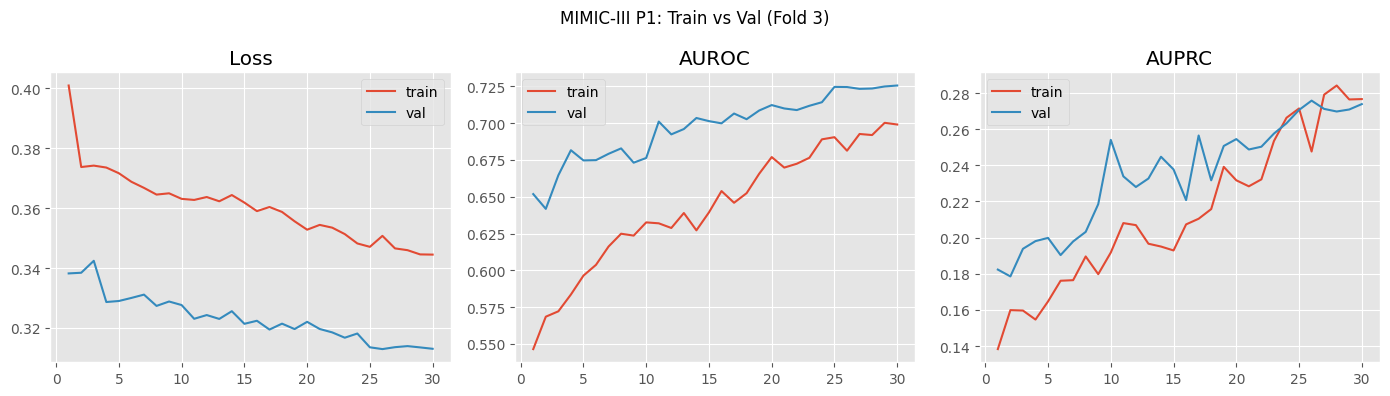

MIMIC-III P2 | Epoch 01 | train_loss=0.4077 val_loss=0.3360 | AUROC train/val=0.522/0.658 | AUPRC train/val=0.142/0.186 | best_val_AUPRC=0.186 | patience=0/7
MIMIC-III P2 | Epoch 02 | train_loss=0.3786 val_loss=0.3309 | AUROC train/val=0.561/0.680 | AUPRC train/val=0.151/0.208 | best_val_AUPRC=0.208 | patience=0/7
MIMIC-III P2 | Epoch 03 | train_loss=0.3703 val_loss=0.3306 | AUROC train/val=0.608/0.683 | AUPRC train/val=0.187/0.209 | best_val_AUPRC=0.208 | patience=1/7
MIMIC-III P2 | Epoch 04 | train_loss=0.3744 val_loss=0.3349 | AUROC train/val=0.587/0.691 | AUPRC train/val=0.171/0.224 | best_val_AUPRC=0.224 | patience=0/7
MIMIC-III P2 | Epoch 05 | train_loss=0.3648 val_loss=0.3579 | AUROC train/val=0.625/0.680 | AUPRC train/val=0.191/0.254 | best_val_AUPRC=0.254 | patience=0/7
MIMIC-III P2 | Epoch 06 | train_loss=0.3599 val_loss=0.3746 | AUROC train/val=0.649/0.681 | AUPRC train/val=0.210/0.225 | best_val_AUPRC=0.254 | patience=1/7
MIMIC-III P2 | Epoch 07 | train_loss=0.3762 val_loss

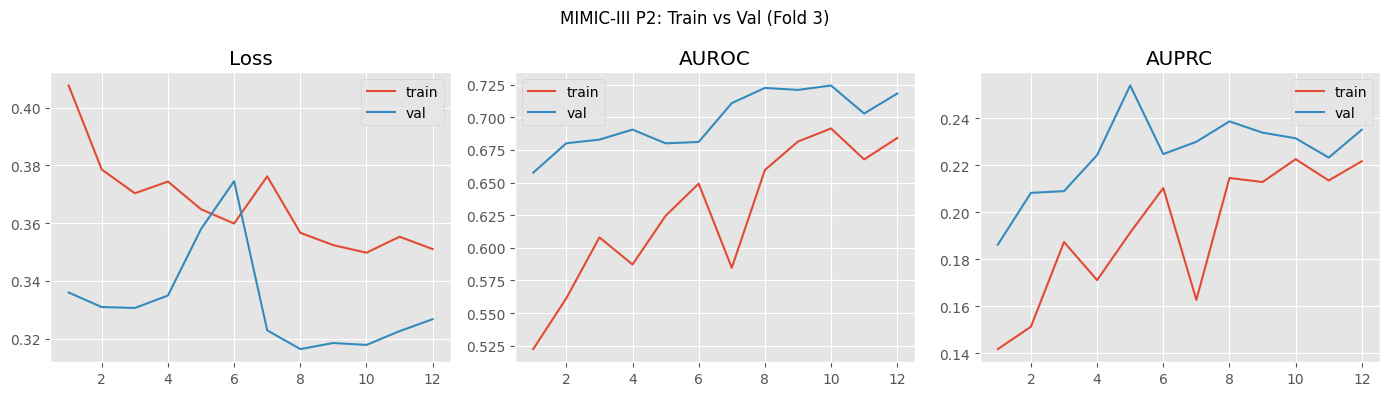

MIMIC-III P3 | Epoch 01 | train_loss=0.3979 val_loss=0.3454 | AUROC train/val=0.519/0.659 | AUPRC train/val=0.131/0.198 | best_val_AUPRC=0.198 | patience=0/7
MIMIC-III P3 | Epoch 02 | train_loss=0.3737 val_loss=0.3293 | AUROC train/val=0.579/0.670 | AUPRC train/val=0.171/0.224 | best_val_AUPRC=0.224 | patience=0/7
MIMIC-III P3 | Epoch 03 | train_loss=0.3693 val_loss=0.3254 | AUROC train/val=0.605/0.688 | AUPRC train/val=0.187/0.252 | best_val_AUPRC=0.252 | patience=0/7
MIMIC-III P3 | Epoch 04 | train_loss=0.3665 val_loss=0.3605 | AUROC train/val=0.622/0.697 | AUPRC train/val=0.181/0.261 | best_val_AUPRC=0.261 | patience=0/7
MIMIC-III P3 | Epoch 05 | train_loss=0.3594 val_loss=0.3165 | AUROC train/val=0.652/0.714 | AUPRC train/val=0.201/0.263 | best_val_AUPRC=0.263 | patience=0/7
MIMIC-III P3 | Epoch 06 | train_loss=0.3608 val_loss=0.3143 | AUROC train/val=0.651/0.728 | AUPRC train/val=0.197/0.267 | best_val_AUPRC=0.267 | patience=0/7
MIMIC-III P3 | Epoch 07 | train_loss=0.3519 val_loss

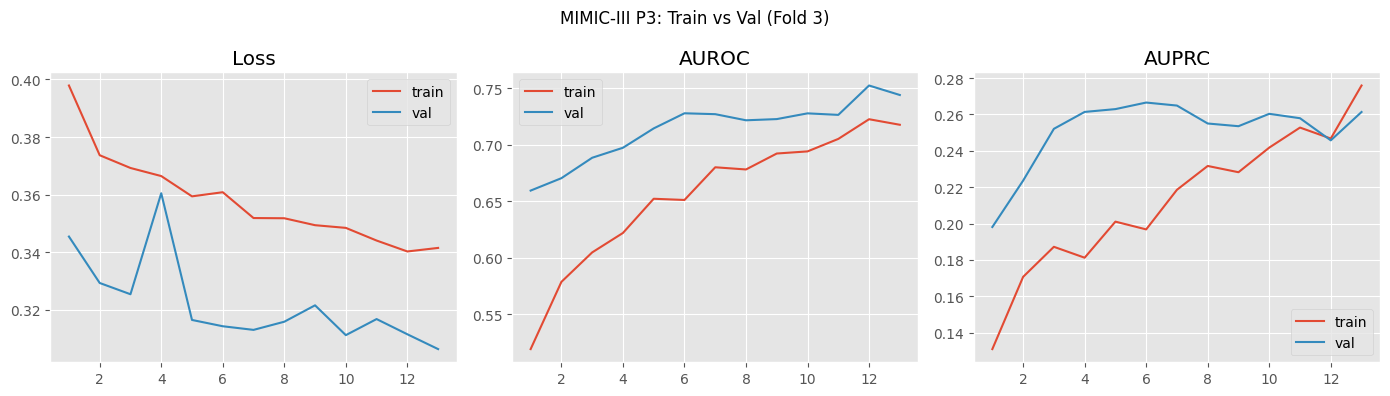

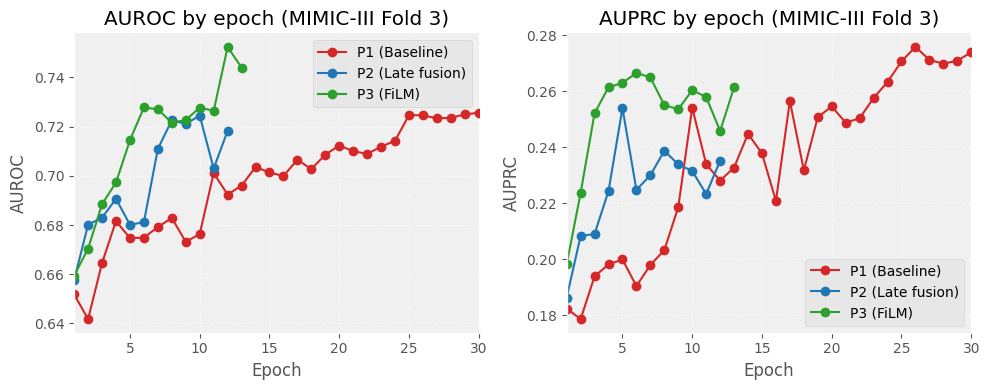

MIMIC-III Fold 3 | Test AUROC P1/P2/P3 = 0.665 / 0.692 / 0.707 | AUPRC P1/P2/P3 = 0.279 / 0.255 / 0.274

MIMIC-III === Fold Results (validation) ===
   fold  P1_AUROC  P1_AUPRC  P2_AUROC  P2_AUPRC  P3_AUROC  P3_AUPRC
0     1     0.675     0.213     0.710     0.259     0.735     0.291
1     2     0.738     0.300     0.767     0.317     0.760     0.316
2     3     0.726     0.274     0.718     0.235     0.744     0.261

MIMIC-III Average (validation):
fold        2.000
P1_AUROC    0.713
P1_AUPRC    0.262
P2_AUROC    0.732
P2_AUPRC    0.270
P3_AUROC    0.746
P3_AUPRC    0.289
dtype: float64


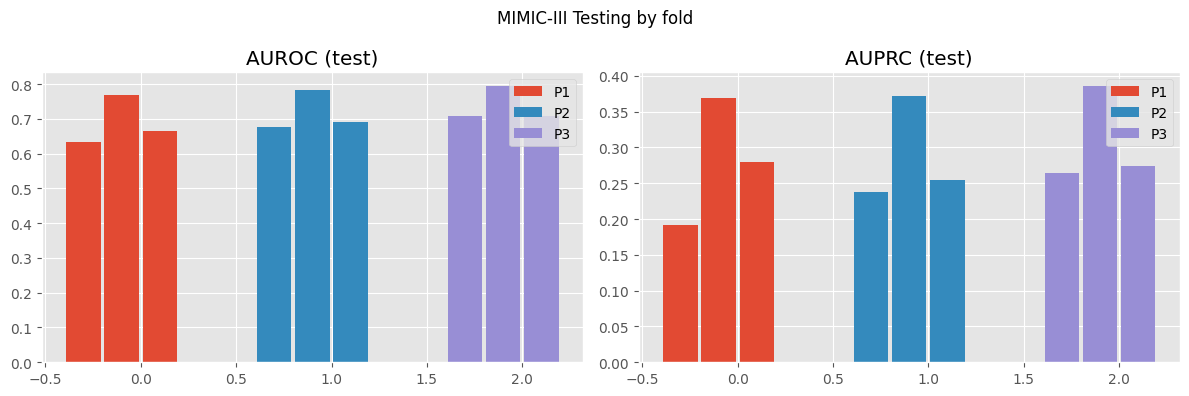

In [33]:
import pickle
import numpy as np
from pathlib import Path

# ============================================================
# 1. CARGA Y PREPARACIÓN DE LOS DATOS
# ============================================================

def load_mimic_glucose_hr(pkl_path: Path):
    """
    Carga mimic_mtan_glucose_hr_7d.pkl y fusiona las series de lab y vital
    en un único eje temporal por episodio.
    """
    print(f"[load_mimic_glucose_hr] Cargando desde: {pkl_path}")

    with open(pkl_path, "rb") as f:
        data = pickle.load(f)

    assert isinstance(data, dict)
    examples = data["examples"]
    ctx_names = data.get("context_feature_names", None)

    lab_itemid = data.get("lab_itemid", None)
    vital_itemid = data.get("vital_itemid", None)
    window_hours = data.get("window_hours", None)

    N = len(examples)
    print("[load_mimic_glucose_hr] example numbers:", N)

    # --- Paso 1: grids de tiempo fusionados ---
    per_episode_T = []
    per_episode_L = []

    for ex in examples:
        t_lab = np.asarray(ex["t_lab"], dtype=np.float32)
        t_vital = np.asarray(ex["t_vital"], dtype=np.float32)

        T_i = np.unique(np.concatenate([t_lab, t_vital]))
        per_episode_T.append(T_i)
        per_episode_L.append(len(T_i))

    L_max = int(max(per_episode_L))
    print("[load_mimic_glucose_hr] Longitudes fusionadas únicas:", sorted(set(per_episode_L)))
    print("[load_mimic_glucose_hr] Longitud máxima L_max:", L_max)

    # --- Paso 2: dim de contexto ---
    ex0 = examples[0]
    context0 = np.asarray(ex0["context"], dtype=np.float32)
    if context0.ndim != 1:
        raise ValueError(f"context del ejemplo 0 no es vector 1D, shape={context0.shape}")
    P_dim = context0.shape[0]
    C = 2  # lab, vital

    # --- Paso 3: inicializar tensores ---
    X_all = np.zeros((N, L_max, C), dtype=np.float32)
    T_all = np.zeros((N, L_max), dtype=np.float32)
    M_all = np.zeros((N, L_max, C), dtype=np.float32)
    y_all = np.zeros((N,), dtype=np.float32)
    user_ids_all = np.empty((N,), dtype=object)
    P_all = np.zeros((N, P_dim), dtype=np.float32)

    # --- Paso 4: rellenar episodio a episodio ---
    for i, ex in enumerate(examples):
        T_i = per_episode_T[i]
        L_i = len(T_i)

        t_lab   = np.asarray(ex["t_lab"], dtype=np.float32)
        x_lab   = np.asarray(ex["x_lab"], dtype=np.float32)
        m_lab   = np.asarray(ex["m_lab"], dtype=np.float32)

        t_vital = np.asarray(ex["t_vital"], dtype=np.float32)
        x_vital = np.asarray(ex["x_vital"], dtype=np.float32)
        m_vital = np.asarray(ex["m_vital"], dtype=np.float32)

        if not (len(t_lab) == len(x_lab) == len(m_lab)):
            raise ValueError(f"[ejemplo {i}] lab con longitudes inconsistentes")
        if not (len(t_vital) == len(x_vital) == len(m_vital)):
            raise ValueError(f"[ejemplo {i}] vital con longitudes inconsistentes")

        lab_dict_x = {float(t): float(v) for t, v in zip(t_lab, x_lab)}
        lab_dict_m = {float(t): float(m) for t, m in zip(t_lab, m_lab)}
        vital_dict_x = {float(t): float(v) for t, v in zip(t_vital, x_vital)}
        vital_dict_m = {float(t): float(m) for t, m in zip(t_vital, m_vital)}

        T_all[i, :L_i] = T_i

        for j, t in enumerate(T_i):
            t_key = float(t)
            if t_key in lab_dict_x:
                X_all[i, j, 0] = lab_dict_x[t_key]
                M_all[i, j, 0] = lab_dict_m[t_key]
            if t_key in vital_dict_x:
                X_all[i, j, 1] = vital_dict_x[t_key]
                M_all[i, j, 1] = vital_dict_m[t_key]

        y_all[i] = float(ex["label"])
        user_ids_all[i] = str(ex["hadm_id"])
        P_all[i, :] = np.asarray(ex["context"], dtype=np.float32)

    print("[load_mimic_glucose_hr] Shapes finales:")
    print("  X_all:", X_all.shape)
    print("  T_all:", T_all.shape)
    print("  M_all:", M_all.shape)
    print("  y_all:", y_all.shape)
    print("  P_all:", P_all.shape)
    print("  user_ids_all:", user_ids_all.shape, type(user_ids_all[0]))
    if ctx_names is not None:
        print("  Nº context_feature_names:", len(ctx_names))

    meta_info = {
        "context_feature_names": ctx_names,
        "lab_itemid": lab_itemid,
        "vital_itemid": vital_itemid,
        "window_hours": window_hours,
        "L_max": L_max,
    }
    return X_all, T_all, M_all, y_all, user_ids_all, P_all, meta_info


# Ruta a tu dataset
DATA_PKL = Path("/home/gmartinez/Tesis/Datasets/MIMIC-III/mimic_mtan_glucose_hr_7d.pkl")
print(">>> Llamando a load_mimic_glucose_hr...")
X_all, T_all, M_all, y_all, user_ids_all, P_all, meta_info = load_mimic_glucose_hr(DATA_PKL)

L_MAX = X_all.shape[1]
in_channels = X_all.shape[2]
p_dim = P_all.shape[1]
print("\nL_MAX:", L_MAX, "in_channels:", in_channels, "p_dim:", p_dim)

# ============================================================
# 2. CONFIGURACIÓN GLOBAL + UTILIDADES
# ============================================================
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import GroupKFold, GroupShuffleSplit
from sklearn.metrics import roc_auc_score, average_precision_score
import matplotlib.pyplot as plt
import pandas as pd
import math
import random

SEED = 42

def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("DEVICE:", DEVICE)

# Hiperparámetros
D_MODEL = 128
N_HEADS = 4
N_LAYERS = 2
DROPOUT = 0.3
LR_BASE = 1e-3
LR_FILM = 7e-4
WEIGHT_DECAY_BASE = 5e-5
WEIGHT_DECAY_FILM = 1e-4
EPOCHS = 30
GRAD_CLIP = 1.0
BATCH_TRAIN = 64
BATCH_VAL = 128
BATCH_TEST = 128
PATIENCE = 7
MIN_DELTA = 1e-3

# ============================================================
# 3. ESTANDARIZACIÓN POR CANAL
# ============================================================

def compute_channel_stats(X_train, M_train):
    B, L, C = X_train.shape
    means = np.zeros((C,), dtype=float)
    stds = np.ones((C,), dtype=float)
    for c in range(C):
        mask_c = M_train[..., c].astype(bool)
        vals = X_train[..., c][mask_c]
        if vals.size == 0:
            means[c] = 0.0
            stds[c] = 1.0
        else:
            means[c] = float(np.mean(vals))
            stds[c] = float(np.std(vals) + 1e-6)
    return means, stds

def standardize_by_stats(X, M, means, stds):
    X_std = (X - means[None, None, :]) / stds[None, None, :]
    X_std = np.where(M == 1.0, X_std, 0.0)
    return X_std

# ============================================================
# 4. DATASETS
# ============================================================
class TimeDataset(Dataset):
    def __init__(self, X, T, M, y, user_ids=None):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.T = torch.tensor(T, dtype=torch.float32)
        self.M = torch.tensor(M, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        self.user_ids = user_ids if user_ids is not None else [None]*len(y)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.T[idx], self.M[idx], self.y[idx], self.user_ids[idx]

class TimeDatasetWithProfile(TimeDataset):
    def __init__(self, X, T, M, y, profiles, user_ids=None):
        super().__init__(X, T, M, y, user_ids)
        self.P = torch.tensor(profiles, dtype=torch.float32)

    def __getitem__(self, idx):
        X, T, M, y, uid = super().__getitem__(idx)
        return X, T, M, y, uid, self.P[idx]

# ============================================================
# 5. MODELOS (mTAN + FiLM)
# ============================================================

class TimeAttentionBlock(nn.Module):
    def __init__(self, d_model, n_heads, dropout=0.2):
        super().__init__()
        self.n_heads = n_heads
        self.d_model = d_model
        self.dk = d_model // n_heads

        self.Wq = nn.Linear(d_model, d_model)
        self.Wk = nn.Linear(d_model, d_model)
        self.Wv = nn.Linear(d_model, d_model)
        self.out = nn.Linear(d_model, d_model)

        self.ln1 = nn.LayerNorm(d_model)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, 4*d_model),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(4*d_model, d_model),
            nn.Dropout(dropout),
        )
        self.ln2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

        self.time_decay = nn.Parameter(torch.tensor(0.1, dtype=torch.float32))

    def forward(self, x, T, M, gamma=None, beta=None):
        B, L, d = x.size()
        Q = self.Wq(x)
        K = self.Wk(x)
        V = self.Wv(x)

        def split_heads(t):
            return t.view(B, L, self.n_heads, self.dk).transpose(1, 2)

        Qh, Kh, Vh = split_heads(Q), split_heads(K), split_heads(V)

        scores = torch.matmul(Qh, Kh.transpose(-2, -1)) / math.sqrt(self.dk)

        Ti = T.unsqueeze(1).unsqueeze(-1)
        Tj = T.unsqueeze(1).unsqueeze(-2)
        time_dist = torch.abs(Ti - Tj)
        scores = scores - torch.clamp(self.time_decay, min=0.0) * time_dist

        step_valid = (M.sum(dim=-1) > 0).unsqueeze(1).unsqueeze(2)
        scores = scores.masked_fill(~step_valid, float("-inf"))

        A = torch.softmax(scores, dim=-1)
        A = self.dropout(A)
        Zh = torch.matmul(A, Vh)
        Z = Zh.transpose(1, 2).contiguous().view(B, L, d)

        h_attn = self.out(Z)
        y1 = self.ln1(x + h_attn)

        if gamma is not None and beta is not None:
            y1 = y1 * gamma + beta

        f = self.ffn(y1)
        y2 = self.ln2(y1 + f)

        if gamma is not None and beta is not None:
            y2 = y2 * gamma + beta

        return y2

class MTANBackbone(nn.Module):
    def __init__(self, in_channels, d_model=128, n_layers=2, n_heads=4, dropout=0.2):
        super().__init__()
        self.input_proj = nn.Linear(in_channels, d_model)
        self.layers = nn.ModuleList([
            TimeAttentionBlock(d_model, n_heads, dropout=dropout)
            for _ in range(n_layers)
        ])
        self.d_model = d_model
        self.n_layers = n_layers

    def forward(self, X, T, M, gammas=None, betas=None):
        h = self.input_proj(X)
        for l, layer in enumerate(self.layers):
            gamma_l = None if gammas is None else gammas[:, l, :].unsqueeze(1)
            beta_l  = None if betas  is None else betas[:, l, :].unsqueeze(1)
            h = layer(h, T, M, gamma=gamma_l, beta=beta_l)
        return h

class FiLMGenerator(nn.Module):
    def __init__(self, p_dim, d_model, n_layers, hidden=64, dropout=0.1):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(p_dim, hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, 2 * n_layers * d_model)
        )
        nn.init.zeros_(self.mlp[-1].weight)
        nn.init.zeros_(self.mlp[-1].bias)
        self.d_model = d_model
        self.n_layers = n_layers

    def forward(self, P):
        B = P.size(0)
        out = self.mlp(P).view(B, 2, self.n_layers, self.d_model)
        gammas = out[:, 0, :, :] + 1.0
        betas  = out[:, 1, :, :]
        return gammas, betas

class HeadMLP(nn.Module):
    def __init__(self, d_in, d_hidden=64, dropout=0.3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_in, d_hidden),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_hidden, 1)
        )
    def forward(self, x):
        return self.net(x).squeeze(-1)

class ModelPhase1_TS(nn.Module):
    def __init__(self, in_channels, d_model=D_MODEL, n_layers=N_LAYERS,
                 n_heads=N_HEADS, dropout=DROPOUT):
        super().__init__()
        self.backbone = MTANBackbone(in_channels, d_model, n_layers, n_heads, dropout)
        self.head = HeadMLP(d_model, d_hidden=64, dropout=dropout)

    def forward(self, X, T, M):
        h = self.backbone(X, T, M, gammas=None, betas=None)
        step_valid = (M.sum(dim=-1) > 0).float()
        denom = torch.clamp(step_valid.sum(dim=1, keepdim=True), min=1.0)
        h_seq = (h * step_valid.unsqueeze(-1)).sum(dim=1) / denom
        return self.head(h_seq)

class ModelPhase2_TSProfile(nn.Module):
    def __init__(self, in_channels, p_dim, d_model=D_MODEL, n_layers=N_LAYERS,
                 n_heads=N_HEADS, dropout=DROPOUT):
        super().__init__()
        self.backbone = MTANBackbone(in_channels, d_model, n_layers, n_heads, dropout)
        self.profile_mlp = nn.Sequential(
            nn.Linear(p_dim, 64),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.head = HeadMLP(d_model + 64, d_hidden=64, dropout=dropout)

    def forward(self, X, T, M, P):
        h = self.backbone(X, T, M, gammas=None, betas=None)
        step_valid = (M.sum(dim=-1) > 0).float()
        denom = torch.clamp(step_valid.sum(dim=1, keepdim=True), min=1.0)
        h_seq = (h * step_valid.unsqueeze(-1)).sum(dim=1) / denom
        h_prof = self.profile_mlp(P)
        return self.head(torch.cat([h_seq, h_prof], dim=-1))

class ModelPhase3_FiLM(nn.Module):
    def __init__(self, in_channels, p_dim, d_model=D_MODEL, n_layers=N_LAYERS,
                 n_heads=N_HEADS, dropout=DROPOUT, film_hidden=64):
        super().__init__()
        self.backbone = MTANBackbone(in_channels, d_model, n_layers, n_heads, dropout)
        self.film = FiLMGenerator(p_dim, d_model, n_layers, hidden=film_hidden, dropout=0.1)
        self.head = HeadMLP(d_model, d_hidden=64, dropout=dropout)

    def forward(self, X, T, M, P):
        gammas, betas = self.film(P)
        h = self.backbone(X, T, M, gammas=gammas, betas=betas)
        step_valid = (M.sum(dim=-1) > 0).float()
        denom = torch.clamp(step_valid.sum(dim=1, keepdim=True), min=1.0)
        h_seq = (h * step_valid.unsqueeze(-1)).sum(dim=1) / denom
        return self.head(h_seq)

# ============================================================
# 6. ENTRENAMIENTO / EVALUACIÓN
# ============================================================

def make_optimizer_and_scheduler(model, phase_name, steps_per_epoch, epochs=EPOCHS):
    if phase_name == "P3":
        lr = LR_FILM
        wd = WEIGHT_DECAY_FILM
    else:
        lr = LR_BASE
        wd = WEIGHT_DECAY_BASE

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)

    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=lr,
        total_steps=steps_per_epoch * epochs,
        pct_start=0.1,
        anneal_strategy="cos",
        div_factor=10.0,
        final_div_factor=10.0,
    )
    return optimizer, scheduler

def train_one_epoch(model, loader, optimizer, scheduler, criterion):
    model.train()
    total_loss = 0.0
    logits_all, targets_all = [], []

    for batch in loader:
        optimizer.zero_grad()

        if len(batch) == 5:
            X, T, M, y, _ = batch
            X, T, M, y = X.to(DEVICE), T.to(DEVICE), M.to(DEVICE), y.to(DEVICE)
            logits = model(X, T, M)
        else:
            X, T, M, y, _, P = batch
            X, T, M, y, P = X.to(DEVICE), T.to(DEVICE), M.to(DEVICE), y.to(DEVICE), P.to(DEVICE)
            logits = model(X, T, M, P)

        loss = criterion(logits, y)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
        optimizer.step()
        scheduler.step()

        total_loss += loss.item() * X.size(0)
        logits_all.append(logits.detach().cpu().numpy())
        targets_all.append(y.detach().cpu().numpy())

    yhat = np.concatenate(logits_all)
    yt = np.concatenate(targets_all)

    try:
        auroc = roc_auc_score(yt, yhat)
    except Exception:
        auroc = np.nan
    try:
        auprc = average_precision_score(yt, yhat)
    except Exception:
        auprc = np.nan

    return total_loss / len(yt), auroc, auprc

@torch.no_grad()
def eval_one_epoch(model, loader, criterion):
    model.eval()
    total_loss = 0.0
    logits_all, targets_all = [], []

    for batch in loader:
        if len(batch) == 5:
            X, T, M, y, _ = batch
            X, T, M, y = X.to(DEVICE), T.to(DEVICE), M.to(DEVICE), y.to(DEVICE)
            logits = model(X, T, M)
        else:
            X, T, M, y, _, P = batch
            X, T, M, y, P = X.to(DEVICE), T.to(DEVICE), M.to(DEVICE), y.to(DEVICE), P.to(DEVICE)
            logits = model(X, T, M, P)

        loss = criterion(logits, y)
        total_loss += loss.item() * X.size(0)
        logits_all.append(logits.detach().cpu().numpy())
        targets_all.append(y.detach().cpu().numpy())

    yhat = np.concatenate(logits_all)
    yt = np.concatenate(targets_all)

    try:
        auroc = roc_auc_score(yt, yhat)
    except Exception:
        auroc = np.nan
    try:
        auprc = average_precision_score(yt, yhat)
    except Exception:
        auprc = np.nan

    return total_loss / len(yt), auroc, auprc

def run_phase(phase_name, train_loader, val_loader, in_channels, p_dim=None, label_prefix=""):
    if phase_name == "P1":
        model = ModelPhase1_TS(in_channels).to(DEVICE)
    elif phase_name == "P2":
        assert p_dim is not None
        model = ModelPhase2_TSProfile(in_channels, p_dim).to(DEVICE)
    elif phase_name == "P3":
        assert p_dim is not None
        model = ModelPhase3_FiLM(in_channels, p_dim).to(DEVICE)
    else:
        raise ValueError("phase_name must be P1, P2 or P3")

    steps_per_epoch = len(train_loader)
    optimizer, scheduler = make_optimizer_and_scheduler(
        model, phase_name, steps_per_epoch, epochs=EPOCHS
    )
    criterion = nn.BCEWithLogitsLoss()

    history = {
        "train_auroc": [], "train_auprc": [],
        "val_auroc": [], "val_auprc": [],
        "train_loss": [], "val_loss": [],
        "lr": []
    }

    best_val_metric = -np.inf
    best_state = None
    patience_counter = 0

    for ep in range(1, EPOCHS + 1):
        tl, tr_auc, tr_pr = train_one_epoch(model, train_loader, optimizer, scheduler, criterion)
        vl, va_auc, va_pr = eval_one_epoch(model, val_loader, criterion)

        history["train_loss"].append(tl)
        history["val_loss"].append(vl)
        history["train_auroc"].append(tr_auc)
        history["val_auroc"].append(va_auc)
        history["train_auprc"].append(tr_pr)
        history["val_auprc"].append(va_pr)
        history["lr"].append(optimizer.param_groups[0]["lr"])

        main_metric = va_pr
        improved = (main_metric - best_val_metric) > MIN_DELTA

        if improved:
            best_val_metric = main_metric
            best_state = {"model": model.state_dict()}
            patience_counter = 0
        else:
            patience_counter += 1

        print(f"{label_prefix} {phase_name} | Epoch {ep:02d} | "
              f"train_loss={tl:.4f} val_loss={vl:.4f} | "
              f"AUROC train/val={tr_auc:.3f}/{va_auc:.3f} | "
              f"AUPRC train/val={tr_pr:.3f}/{va_pr:.3f} | "
              f"best_val_AUPRC={best_val_metric:.3f} | patience={patience_counter}/{PATIENCE}")

        if patience_counter >= PATIENCE:
            print(f"{label_prefix} {phase_name} | Early stopping epoch {ep}")
            break

    if best_state is not None:
        model.load_state_dict(best_state["model"])
    return model, history

# ============================================================
# 7. GRÁFICAS (con longitudes distintas)
# ============================================================

def plot_history(history, title):
    epochs = range(1, len(history["train_loss"]) + 1)
    fig, axs = plt.subplots(1, 3, figsize=(14, 4))

    axs[0].plot(epochs, history["train_loss"], label="train")
    axs[0].plot(epochs, history["val_loss"], label="val")
    axs[0].set_title("Loss"); axs[0].legend()

    axs[1].plot(epochs, history["train_auroc"], label="train")
    axs[1].plot(epochs, history["val_auroc"], label="val")
    axs[1].set_title("AUROC"); axs[1].legend()

    axs[2].plot(epochs, history["train_auprc"], label="train")
    axs[2].plot(epochs, history["val_auprc"], label="val")
    axs[2].set_title("AUPRC"); axs[2].legend()

    fig.suptitle(title)
    plt.tight_layout()
    return fig

def plot_testing_bars(test_metrics, title):
    phases = ["P1", "P2", "P3"]
    n_folds = max(len(test_metrics[p]) for p in phases)
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    for i, p in enumerate(phases):
        aurocs = [m[0] for m in test_metrics[p]]
        xs = [i + (j - n_folds / 2) * 0.2 for j in range(len(aurocs))]
        axs[0].bar(xs, aurocs, width=0.18, label=p)
    axs[0].set_title("AUROC (test)"); axs[0].legend()

    for i, p in enumerate(phases):
        auprcs = [m[1] for m in test_metrics[p]]
        xs = [i + (j - n_folds / 2) * 0.2 for j in range(len(auprcs))]
        axs[1].bar(xs, auprcs, width=0.18, label=p)
    axs[1].set_title("AUPRC (test)"); axs[1].legend()

    fig.suptitle(title)
    plt.tight_layout()
    return fig

def plot_auroc_auprc_by_epoch_phases(
    hist_p1,
    hist_p2,
    hist_p3,
    cohort_label="cohorte X",
    use_validation=True,
    figsize=(10, 4),
    save_path=None
):
    """
    Maneja historias de distinta longitud (por early stopping).
    Cada modelo usa su propio vector de épocas.
    """
    metric_suffix = "val" if use_validation else "train"
    auroc_key = f"{metric_suffix}_auroc"
    auprc_key = f"{metric_suffix}_auprc"

    plt.style.use("ggplot")
    fig, axes = plt.subplots(1, 2, figsize=figsize)

    color_p1 = "#d62728"
    color_p2 = "#1f77b4"
    color_p3 = "#2ca02c"

    # ---------- AUROC ----------
    ax = axes[0]
    for hist, label, color in [
        (hist_p1, "P1 (Baseline)", color_p1),
        (hist_p2, "P2 (Late fusion)", color_p2),
        (hist_p3, "P3 (FiLM)", color_p3),
    ]:
        y = np.array(hist[auroc_key])
        x = np.arange(1, len(y) + 1)
        ax.plot(x, y, label=label, color=color, marker="o")

    max_len = max(len(hist_p1[auroc_key]), len(hist_p2[auroc_key]), len(hist_p3[auroc_key]))
    ax.set_title(f"AUROC by epoch ({cohort_label})")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("AUROC")
    ax.grid(True, linestyle="--", alpha=0.5)
    ax.set_xlim(1, max_len)
    ax.legend(loc="best")

    # ---------- AUPRC ----------
    ax = axes[1]
    for hist, label, color in [
        (hist_p1, "P1 (Baseline)", color_p1),
        (hist_p2, "P2 (Late fusion)", color_p2),
        (hist_p3, "P3 (FiLM)", color_p3),
    ]:
        y = np.array(hist[auprc_key])
        x = np.arange(1, len(y) + 1)
        ax.plot(x, y, label=label, color=color, marker="o")

    max_len_pr = max(len(hist_p1[auprc_key]), len(hist_p2[auprc_key]), len(hist_p3[auprc_key]))
    ax.set_title(f"AUPRC by epoch ({cohort_label})")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("AUPRC")
    ax.grid(True, linestyle="--", alpha=0.5)
    ax.set_xlim(1, max_len_pr)
    ax.legend(loc="best")

    for ax in axes:
        ax.set_facecolor("#f0f0f0")
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)

    fig.tight_layout()
    if save_path is not None:
        fig.savefig(save_path, dpi=300, bbox_inches="tight")
    return fig, axes

# ============================================================
# 8. ORQUESTACIÓN CV + TEST
# ============================================================

def run_mimic_pipeline(X_all, T_all, M_all, y_all, user_ids_all, P_all,
                       n_splits_cv=3, test_size=0.2, label_prefix="MIMIC-III"):
    has_profiles = P_all is not None
    p_dim = None if not has_profiles else P_all.shape[1]

    groups_by_instance = np.array(user_ids_all)
    gss = GroupShuffleSplit(n_splits=1, test_size=test_size, random_state=SEED)
    trainval_idx, test_idx = next(gss.split(X_all, y_all, groups=groups_by_instance))

    users_tv = [user_ids_all[i] for i in trainval_idx]
    users_te = [user_ids_all[i] for i in test_idx]

    print(f"{label_prefix} Train/Val instances: {len(trainval_idx)} | "
          f"Test instances: {len(test_idx)} | "
          f"TV users: {len(set(users_tv))} | "
          f"Test users: {len(set(users_te))}")

    X_tv, T_tv, M_tv, y_tv = X_all[trainval_idx], T_all[trainval_idx], M_all[trainval_idx], y_all[trainval_idx]
    X_te, T_te, M_te, y_te = X_all[test_idx], T_all[test_idx], M_all[test_idx], y_all[test_idx]
    if has_profiles:
        P_tv, P_te = P_all[trainval_idx], P_all[test_idx]
    else:
        P_tv = P_te = None

    gkf = GroupKFold(n_splits=n_splits_cv)

    results_val = []
    test_metrics = {"P1": [], "P2": [], "P3": []}
    fold_counter = 0
    in_channels = X_all.shape[2]

    for tr_idx_rel, va_idx_rel in gkf.split(X_tv, y_tv, groups=np.array(users_tv)):
        fold_counter += 1
        print(f"{label_prefix} === Fold {fold_counter} ===")

        X_tr, T_tr, M_tr, y_tr = X_tv[tr_idx_rel], T_tv[tr_idx_rel], M_tv[tr_idx_rel], y_tv[tr_idx_rel]
        X_va, T_va, M_va, y_va = X_tv[va_idx_rel], T_tv[va_idx_rel], M_tv[va_idx_rel], y_tv[va_idx_rel]
        u_tr = [users_tv[i] for i in tr_idx_rel]
        u_va = [users_tv[i] for i in va_idx_rel]

        if has_profiles:
            P_tr, P_va = P_tv[tr_idx_rel], P_tv[va_idx_rel]

        means, stds = compute_channel_stats(X_tr, M_tr)
        X_tr_std = standardize_by_stats(X_tr, M_tr, means, stds)
        X_va_std = standardize_by_stats(X_va, M_va, means, stds)

        ds_tr_p1 = TimeDataset(X_tr_std, T_tr, M_tr, y_tr, user_ids=u_tr)
        ds_va_p1 = TimeDataset(X_va_std, T_va, M_va, y_va, user_ids=u_va)
        dl_tr_p1 = DataLoader(ds_tr_p1, batch_size=BATCH_TRAIN, shuffle=True, drop_last=False)
        dl_va_p1 = DataLoader(ds_va_p1, batch_size=BATCH_VAL, shuffle=False, drop_last=False)

        if has_profiles:
            ds_tr_p2 = TimeDatasetWithProfile(X_tr_std, T_tr, M_tr, y_tr, profiles=P_tr, user_ids=u_tr)
            ds_va_p2 = TimeDatasetWithProfile(X_va_std, T_va, M_va, y_va, profiles=P_va, user_ids=u_va)
            dl_tr_p2 = DataLoader(ds_tr_p2, batch_size=BATCH_TRAIN, shuffle=True, drop_last=False)
            dl_va_p2 = DataLoader(ds_va_p2, batch_size=BATCH_VAL, shuffle=False, drop_last=False)
            dl_tr_p3 = dl_tr_p2
            dl_va_p3 = dl_va_p2

        # ----- Entrenar P1, P2, P3 -----
        model_p1, hist_p1 = run_phase("P1", dl_tr_p1, dl_va_p1, in_channels, label_prefix=label_prefix)
        plot_history(hist_p1, title=f"{label_prefix} P1: Train vs Val (Fold {fold_counter})")
        plt.show()

        if has_profiles:
            model_p2, hist_p2 = run_phase("P2", dl_tr_p2, dl_va_p2, in_channels, p_dim=p_dim, label_prefix=label_prefix)
            plot_history(hist_p2, title=f"{label_prefix} P2: Train vs Val (Fold {fold_counter})")
            plt.show()

            model_p3, hist_p3 = run_phase("P3", dl_tr_p3, dl_va_p3, in_channels, p_dim=p_dim, label_prefix=label_prefix)
            plot_history(hist_p3, title=f"{label_prefix} P3: Train vs Val (Fold {fold_counter})")
            plt.show()

            fig_phases, axes_phases = plot_auroc_auprc_by_epoch_phases(
                hist_p1, hist_p2, hist_p3,
                cohort_label=f"{label_prefix} Fold {fold_counter}",
                use_validation=True,
                figsize=(10, 4),
            )
            plt.show()

        # ----- métricas en validación -----
        vl_p1, va_auc_p1, va_pr_p1 = eval_one_epoch(model_p1, dl_va_p1, nn.BCEWithLogitsLoss())

        if has_profiles:
            vl_p2, va_auc_p2, va_pr_p2 = eval_one_epoch(model_p2, dl_va_p2, nn.BCEWithLogitsLoss())
            vl_p3, va_auc_p3, va_pr_p3 = eval_one_epoch(model_p3, dl_va_p3, nn.BCEWithLogitsLoss())
        else:
            va_auc_p2 = va_pr_p2 = np.nan
            va_auc_p3 = va_pr_p3 = np.nan

        results_val.append({
            "fold": fold_counter,
            "P1_AUROC": va_auc_p1, "P1_AUPRC": va_pr_p1,
            "P2_AUROC": va_auc_p2, "P2_AUPRC": va_pr_p2,
            "P3_AUROC": va_auc_p3, "P3_AUPRC": va_pr_p3,
        })

        # ----- evaluación en test -----
        X_te_std = standardize_by_stats(X_te, M_te, means, stds)
        ds_te_p1 = TimeDataset(X_te_std, T_te, M_te, y_te, user_ids=users_te)
        dl_te_p1 = DataLoader(ds_te_p1, batch_size=BATCH_TEST, shuffle=False, drop_last=False)

        _, te_auc_p1, te_pr_p1 = eval_one_epoch(model_p1, dl_te_p1, nn.BCEWithLogitsLoss())
        test_metrics["P1"].append((te_auc_p1, te_pr_p1))

        if has_profiles:
            ds_te_p2 = TimeDatasetWithProfile(X_te_std, T_te, M_te, y_te, profiles=P_te, user_ids=users_te)
            dl_te_p2 = DataLoader(ds_te_p2, batch_size=BATCH_TEST, shuffle=False, drop_last=False)

            _, te_auc_p2, te_pr_p2 = eval_one_epoch(model_p2, dl_te_p2, nn.BCEWithLogitsLoss())
            _, te_auc_p3, te_pr_p3 = eval_one_epoch(model_p3, dl_te_p2, nn.BCEWithLogitsLoss())

            test_metrics["P2"].append((te_auc_p2, te_pr_p2))
            test_metrics["P3"].append((te_auc_p3, te_pr_p3))

            print(f"{label_prefix} Fold {fold_counter} | Test AUROC P1/P2/P3 = "
                  f"{te_auc_p1:.3f} / {te_auc_p2:.3f} / {te_auc_p3:.3f} | "
                  f"AUPRC P1/P2/P3 = {te_pr_p1:.3f} / {te_pr_p2:.3f} / {te_pr_p3:.3f}")
        else:
            print(f"{label_prefix} Fold {fold_counter} | Test AUROC P1 = {te_auc_p1:.3f} | "
                  f"AUPRC P1 = {te_pr_p1:.3f}")

    res_df = pd.DataFrame(results_val)
    print(f"\n{label_prefix} === Fold Results (validation) ===")
    print(res_df.round(3))
    print(f"\n{label_prefix} Average (validation):")
    print(res_df.mean(numeric_only=True).round(3))

    if any(len(v) > 0 for v in test_metrics.values()):
        plot_testing_bars(test_metrics, title=f"{label_prefix} Testing by fold")
        plt.show()

    return res_df, test_metrics

# ============================================================
# 9. EJECUTAR PIPELINE
# ============================================================
res_val, test_metrics = run_mimic_pipeline(
    X_all, T_all, M_all, y_all, user_ids_all, P_all,
    n_splits_cv=3,
    test_size=0.2,
    label_prefix="MIMIC-III"
)